In [1]:
import os
import sys
import psutil

import pandas as pd
import numpy as np

import keras
import random

from keras.models import Sequential,Model
from keras.layers import Dense,LSTM,Activation,Dropout,BatchNormalization,Input,Embedding
from keras.layers import Flatten,Conv2D,MaxPooling2D,Bidirectional,concatenate

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras import optimizers
import keras_metrics as km

import matplotlib
import matplotlib.pyplot as plt
import math
from multiprocessing import cpu_count,Pool 
import multiprocessing


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from keras.utils import np_utils
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.metrics import make_scorer
from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import roc_curve, auc

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from keras_self_attention import SeqSelfAttention


/usr/local/anaconda5/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    weights = K.variable(weights)      
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [3]:
SEQ=8
verbose = 2
dropout=0.3
ACT_POSTERIOR = 'relu'
weights = np.array([0.2,0.8])
patience = 10
weight_decay = 0.0001
lr=0.1
lr_decay=1e-6

LSTM_UNIT = 128
GEOHASH_UNIT = 32
EMBEDDING_UNIT = 128
NLP_UNIT = 128
SEQ_UNIT = 256
ACT_PRIOR = 'sigmoid'
DENSE_CONCAT = 256
VAL_SPLIT = 0.2
CONV_UNIT = 32
ADD_ON_LAYERS = True
Embedding_outdim = 100

In [4]:
def reshape_cat(array,category):
    l=[]
    b = array[:,0:-114]
    if category!='geohash' and  category!='NLP' :
        for i in range(SEQ):
            c = b[:,i*25:i*25+25]
            if category == 'traffic':
                #d = np.concatenate((c[:,0:9],c[:,-5:]),axis=1)
                d = np.concatenate([c[:,1:2],c[:,3:10]],axis=1)
            elif category=='weather':
                d = c[:,10:-5]
            elif category=='time':
                d = np.concatenate([c[:,0:1],c[:,2:3],c[:,-5:]],axis=1) 
            else:
                d = c
            l.append(d)        
        n = np.concatenate(l,axis=1)
        #if category!='no_geohash':
        #    return np.concatenate((n,array[:,-14:]),axis=1)
        return n
    elif category=='NLP':
        return array[:,-100:]
    else:
        return array[:,-114:-100]

In [5]:
# Compute ROC curve and ROC area for each class
def roc_auc_compute(y_test,y_score,n_classes=2):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i],pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel(),pos_label=1)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    return fpr,tpr,roc_auc
def plot_roc(fpr,tpr,roc_auc,n_classes=2):
    lw = 2
# Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    
    plt.figure(2)
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [6]:
class base_model(object):        
    def __init__(self,n_jobs=10,act=ACT_POSTERIOR,city='Atlanta'): 
        self.n_jobs=n_jobs
        self.CITY=city
        self.act=act
   
    def load_data(self,category=None,with_geocode=False):
        self.X_train = np.load('train_set/X_train_'+self.CITY+'.npy')
        self.y_train = np.load('train_set/y_train_'+self.CITY+'.npy')
        self.X_test = np.load('train_set/X_test_'+self.CITY+'.npy')
        self.y_test = np.load('train_set/y_test_'+self.CITY+'.npy')
        
        if not with_geocode:
            self.X_train = self.X_train[:,0:-1]    
            self.X_test = self.X_test[:,0:-1]     
        self.update_y()   
        
        if category!=None:
            if with_geocode:
                temp_train = self.X_train[:,0:-1]    
                temp_test = self.X_test[:,0:-1]   
            else:
                temp_train = self.X_train 
                temp_test = self.X_test  
            l_train=[]
            l_test=[]
            for cat in category:
                l_train.append(reshape_cat(temp_train,cat))
                l_test.append(reshape_cat(temp_test,cat))
            temp_train = np.concatenate(l_train,axis=1)
            temp_test = np.concatenate(l_test,axis=1)
            if with_geocode:
                #print (self.X_train[:,-1:])
                self.X_train = np.concatenate((temp_train,self.X_train[:,-1:]),axis=1)
                self.X_test = np.concatenate((temp_test,self.X_test[:,-1:]),axis=1)
            else:
                self.X_train = temp_train
                self.X_test = temp_test
                
        print ('load and test: shapes for train and test, X/Y')
        print (self.X_train.shape)
        print (self.y_train.shape)
        print (self.X_test.shape)
        print (self.y_test.shape)
    
    def update_y(self):
        self.y_train = to_categorical(self.y_train,2)
        self.y_test = to_categorical(self.y_test,2)
    def last_layers(self,model_in):
        model_in = Dense(DENSE_CONCAT,
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=self.act)(model_in)
        
        model_in = Dense(units=int(DENSE_CONCAT/2),
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=None)(model_in)
        if ADD_ON_LAYERS:
            model_in = BatchNormalization()(model_in)
        model_in = Activation(self.act)(model_in)
        model_in = Dropout(dropout)(model_in)
        
        model_in = Dense(units=int(DENSE_CONCAT/8),
                    kernel_regularizer=regularizers.l2(self.weight_decay),
                    activation=None)(model_in)
        if ADD_ON_LAYERS:
            model_in = BatchNormalization()(model_in)
        model_in = Activation(self.act)(model_in)
        #model_in = Dropout(dropout)(model_in)
        ######################################
        main_output = Dense(self.output_dim, activation=self.activation)(model_in)
        return main_output
        
class keras_model(base_model):
    def __init__(self,city='Atlanta',activation='softmax',batch_size=256,epoch = 60,n_jobs=1,act=ACT_POSTERIOR):
        super(keras_model,self).__init__(act=act,city=city)
        self.output_dim = 2
        self.activation=activation
        self.batch_size = batch_size
        self.epoch = epoch
        self.n_jobs=n_jobs
        self.weight_decay = weight_decay
        self.lr=lr
        self.lr_decay=lr_decay
        
    def reshape(self,x):
        x = x[:,0:-114]
        x = x.reshape((x.shape[0],SEQ,int(x.shape[1]/SEQ)))
        return x
    
    def compile_model(self,model=None):
        #precision = km.categorical_precision(label=1)
        #recall = km.categorical_recall(label=1)
        f1_score = km.categorical_f1_score(label=1)
        self.earlyStopping = EarlyStopping(monitor='val_f1_score', 
                                           #monitor = 'val_categorical_f1_score',
                                           restore_best_weights=True,
                                           patience=patience, verbose=0, mode='max'#,baseline=0.1
                                          )
        adam  = optimizers.Adam(lr=self.lr, decay=self.lr_decay)
        loss=weighted_categorical_crossentropy(weights)
        self.model.compile(optimizer=adam, loss=loss#'categorical_crossentropy'
                           ,metrics=[f1_score])
    def create_model(self):
        self.model = KerasClassifier(build_fn=self.build_model, epochs=self.epoch, batch_size=self.batch_size, verbose=1)
    def make_report(self,y_true,y_pred):
        data_frame = classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),output_dict=True)
        df = pd.DataFrame(data_frame)
        df = df.reset_index()
        roc_dict = self.roc_auc(y_true,y_pred)
        df = df.append({'index':'auc','0': roc_dict[0], '1': roc_dict[1],
                   'micro avg': roc_dict['micro'],
                   'macro avg':roc_dict['macro']}, ignore_index=True)
        df = df.set_index('index')
        display(df)
        return df
        
    def roc_auc(self,y_test,y_score):
        fpr,tpr,roc_auc = roc_auc_compute(y_test,y_score)
        plot_roc(fpr,tpr,roc_auc)
        return roc_auc
         
        

In [7]:
class DNN(keras_model):
        
    def create_model(self):
        input1 = Input(shape=(self.X_train.shape[1],),dtype='float32',name='main_input')
        main_output = self.last_layers(input1)
        
        self.model = Model(inputs=[input1], outputs=main_output)
        
        
        #keras.layers.Dense(units, activation=None, use_bias=True, 
        #kernel_initializer='glorot_uniform', bias_initializer='zeros', 
        #kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, 
        #kernel_constraint=None, bias_constraint=None)
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit(self.X_train, self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict(self.X_test,verbose=verbose)
        return self.make_report(y_true, y_pred)
        

In [8]:
class model_LSTM_aug_wo_NLP_wo_geohash(keras_model):       
    def load_data(self,category):
        super(model_LSTM_aug_wo_NLP_wo_geohash,self).load_data(category)
        self.X_train1 = self.reshape(self.X_train)
        self.X_test1 = self.reshape(self.X_test)
        
        #self.X_train2 = reshape_cat(self.X_train,'geohash')
        #self.X_train3 = reshape_cat(self.X_train,'NLP')
        
        #self.X_test2 = reshape_cat(self.X_test,'geohash')
        #self.X_test3 = reshape_cat(self.X_test,'NLP')
        
        print (self.X_train1.shape)
        #print (self.X_train2.shape)
        #print (self.X_train3.shape)
        
    def create_model(self):
        
        input1 = Input(shape=(self.X_train1.shape[1], self.X_train1.shape[2]),dtype='float32', 
                           name='main_input')
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(input1)
        
        lstm = LSTM(units = LSTM_UNIT, return_sequences = False,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(lstm)
        ######################################
        #input2 = Input(shape=(self.X_train2.shape[1],), dtype='float32', name='geohash_input')
        #geohash_vec = Dense(GEOHASH_UNIT, activation=ACT_PRIOR)(input2)
        ######################################
        #input3 = Input(shape=(self.X_train3.shape[1],), dtype='float32', name='nlp_input')
        #nlp_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(input3)
        ######################################
        level_2 = lstm
        #print (lstm.shape)
        main_output = self.last_layers(level_2)
        #print (main_output.shape)
        self.model = Model(inputs=input1, outputs=main_output)
        
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit(self.X_train1, self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict(self.X_test1,verbose=verbose)
        return self.make_report(y_true, y_pred)
        

In [9]:
class model_LSTM_aug_embed_wo_NLP_wo_geohash(keras_model):
    
    def load_data(self,category):
        super(model_LSTM_aug_embed_wo_NLP_wo_geohash,self).load_data(category,with_geocode=True)
        
        self.X_train1 = self.reshape(self.X_train[:,:-1])
        self.X_test1 = self.reshape(self.X_test[:,:-1])
        
        #self.X_train2 = reshape_cat(self.X_train[:,:-1],'geohash')
        #self.X_train3 = reshape_cat(self.X_train[:,:-1],'NLP')
        
        #self.X_test2 = reshape_cat(self.X_test[:,:-1],'geohash')
        #self.X_test3 = reshape_cat(self.X_test[:,:-1],'NLP')
        
        self.X_train4 = self.X_train[:,-1]
        self.X_test4 = self.X_test[:,-1]
        
        print (self.X_train1.shape)
        #print (self.X_train2.shape)
        #print (self.X_train3.shape)
        print (self.X_train4.shape)
        
    def create_model(self):
        
        input1 = Input(shape=(self.X_train1.shape[1], self.X_train1.shape[2]),dtype='float32', 
                           name='main_input')
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(input1)
        
        lstm = LSTM(units = LSTM_UNIT, return_sequences = False,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(lstm)
        ######################################
        #input2 = Input(shape=(self.X_train2.shape[1],), dtype='float32', name='geohash_input')
        #geohash_vec = Dense(GEOHASH_UNIT, activation=ACT_PRIOR)(input2)
        ######################################
        #input3 = Input(shape=(self.X_train3.shape[1],), dtype='float32', name='nlp_input')
        #nlp_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(input3)
        ######################################
        input4 = Input(shape=(1,),dtype='int32',name='geo_code')
        embeding = Embedding(input_dim=935, output_dim=Embedding_outdim, embeddings_initializer='uniform',input_length=1)(input4)
        embeding = Flatten()(embeding)
        embeding = Dense(EMBEDDING_UNIT, activation=ACT_PRIOR)(embeding)
        ######################################
        level_3 = concatenate([lstm,embeding])
        
        main_output = self.last_layers(level_3)
        
        self.model = Model(inputs=[input1,input4], outputs=main_output)
        
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit([self.X_train1,self.X_train4], self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict([self.X_test1,self.X_test4],verbose=verbose)
        return self.make_report(y_true, y_pred)
        
        


In [10]:
class model_LSTM_aug_embed_att_wo_NLP_wo_geohash(keras_model):
    
    def load_data(self,category):
        super(model_LSTM_aug_embed_att_wo_NLP_wo_geohash,self).load_data(category,with_geocode=True)
        
        self.X_train1 = self.reshape(self.X_train[:,:-1])
        self.X_test1 = self.reshape(self.X_test[:,:-1])
        
        #self.X_train2 = reshape_cat(self.X_train[:,:-1],'geohash')
        #self.X_train3 = reshape_cat(self.X_train[:,:-1],'NLP')
        
        #self.X_test2 = reshape_cat(self.X_test[:,:-1],'geohash')
        #self.X_test3 = reshape_cat(self.X_test[:,:-1],'NLP')
        
        self.X_train4 = self.X_train[:,-1]
        self.X_test4 = self.X_test[:,-1]
        
        print (self.X_train1.shape)
        #print (self.X_train2.shape)
        #print (self.X_train3.shape)
        print (self.X_train4.shape)
        
    def create_model(self):
        
        input1 = Input(shape=(self.X_train1.shape[1], self.X_train1.shape[2]),dtype='float32', 
                           name='main_input')
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(input1)
        lstm = LSTM(units = LSTM_UNIT, return_sequences = True,
                     kernel_regularizer=regularizers.l2(self.weight_decay),
                     recurrent_regularizer = regularizers.l2(self.weight_decay),
                     dropout=dropout,
                     recurrent_dropout=dropout,
                     unroll = True)(lstm)
        
        lstm = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                                kernel_regularizer=keras.regularizers.l2(self.weight_decay),
                                bias_regularizer=keras.regularizers.l1(self.weight_decay),
                                   attention_regularizer_weight=self.weight_decay,
                                attention_activation=self.act)(lstm)
        lstm = Flatten()(lstm)
        
        lstm_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(lstm)
        """
        att = Dense(1, activation='tanh')(LSTM1)
        att = Activation('softmax')(att)
        merge = keras.layers.Multiply()([LSTM1,att])
        
        att = SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                      
                       
                       name='Attention')(lstm)
        """ 
        
        ######################################
        #input2 = Input(shape=(self.X_train2.shape[1],), dtype='float32', name='geohash_input')
        #geohash_vec = Dense(GEOHASH_UNIT, activation=ACT_PRIOR)(input2)
        ######################################
        #input3 = Input(shape=(self.X_train3.shape[1],), dtype='float32', name='nlp_input')
        #nlp_vec = Dense(NLP_UNIT, activation=ACT_PRIOR)(input3)
        ######################################
        input4 = Input(shape=(1,),dtype='int32',name='geo_code')
        embeding = Embedding(input_dim=935, output_dim=Embedding_outdim, embeddings_initializer='uniform',input_length=1)(input4)
        embeding = Flatten()(embeding)
        embeding = Dense(EMBEDDING_UNIT, activation=ACT_PRIOR)(embeding)
        ######################################
        level_3 = concatenate([lstm_vec,embeding])
        
        main_output = self.last_layers(level_3)
        self.model = Model(inputs=[input1,input4], outputs=main_output)
        
        print(self.model.summary())
        
    def train(self):
        history = self.model.fit([self.X_train1,self.X_train4], self.y_train, batch_size=self.batch_size, 
                                 epochs=self.epoch,verbose=verbose,validation_split=VAL_SPLIT, callbacks=[self.earlyStopping])        
    def evaluate(self):    
        y_true, y_pred =  self.y_test, self.model.predict([self.X_test1,self.X_test4],verbose=verbose)
        return self.make_report(y_true, y_pred)


In [11]:

    
def compare_models(city='Atlanta',vr=2,drop=0.2,val_split=0.2,p=15,w_d=0,LR=0.01,lr_dc=1e-6,
                   add_on_layer=True,
                   w=[1,1],
                   act_prior = 'sigmoid',act_posterior='relu',
                   lstm_unit=128,geohash_unit=128,embedding_unit=128,nlp_unit=128,seq_unit=256,
                   dense_concat=512,conv_unit=32,classname='DNN'
                  ):

    #global SEQ=8
    global verbose
    global dropout
    global ACT_POSTERIOR
    global ACT_PRIOR
    global weights
    global patience
    global weight_decay
    global lr
    global lr_decay
    
    global GEOHASH_UNIT
    global EMBEDDING_UNIT 
    global NLP_UNIT
    global SEQ_UNIT
    
    global LSTM_UNIT
    global DENSE_CONCAT
    global CONV_UNIT
    global ADD_ON_LAYER
    global VAL_SPLIT
    global Embedding_outdim
    verbose = vr
    dropout=drop
    weights = np.array(w)
    patience = p
    weight_decay = w_d
    lr=LR
    lr_decay=lr_dc
    
    ACT_PRIOR = act_prior
    ACT_POSTERIOR = act_posterior
    
    LSTM_UNIT = lstm_unit
    GEOHASH_UNIT = geohash_unit
    EMBEDDING_UNIT = embedding_unit
    NLP_UNIT = nlp_unit
    SEQ_UNIT = seq_unit
    DENSE_CONCAT = dense_concat
    CONV_UNIT = conv_unit
    Embedding_outdim = embedding_unit
    
    ADD_ON_LAYER = add_on_layer
    VAL_SPLIT = val_split
    def initialte_class(classname):
        if classname=='DNN':
            mypred = DNN(city=city)
            return mypred
        if classname=='RNN':
            mypred = model_LSTM_aug(city=city)
            return mypred
        if classname=='RNN_wo_geohash':
            mypred = model_LSTM_aug_wo_geohash(city=city)
            return mypred
        if classname=='RNN_wo_NLP':
            mypred = model_LSTM_aug_wo_NLP(city=city)
            return mypred
        
        if classname=='RNN_wo_NLP_wo_geohash':
            mypred = model_LSTM_aug_wo_NLP_wo_geohash(city=city)
            return mypred
        
        
        if classname=='RNN_embed':
            mypred = model_LSTM_aug_embed(city=city)
            return mypred
        
        if classname=='RNN_embed_wo_geohash':
            mypred = model_LSTM_aug_embed_wo_geohash(city=city)
            return mypred
        
        if classname=='RNN_embed_wo_NLP':
            mypred = model_LSTM_aug_embed_wo_NLP(city=city)
            return mypred
        
        if classname=='RNN_embed_wo_NLP_wo_geohash':
            mypred = model_LSTM_aug_embed_wo_NLP_wo_geohash(city=city)
            return mypred
        
        
        if classname=='RNN_embed_att':
            mypred = model_LSTM_aug_embed_att(city=city)
            return mypred
        
        if classname=='RNN_embed_att_wo_geohash':
            mypred = model_LSTM_aug_embed_att_wo_geohash(city=city)
            return mypred
        
        if classname=='RNN_embed_att_wo_NLP':
            mypred = model_LSTM_aug_embed_att_wo_NLP(city=city)
            return mypred
        
        if classname=='RNN_embed_att_wo_NLP_wo_geohash':
            mypred = model_LSTM_aug_embed_att_wo_NLP_wo_geohash(city=city)
            return mypred
        
        
        
        
        print ('error in name')
        raise
        return None        
    def do_rest(pred,category):
        pred.load_data(category)
        pred.create_model()
        pred.compile_model()
        pred.train()
        return pred
    
    def process_frame(df,i):
        new_df = df[['0','1','weighted avg','micro avg','macro avg']].drop('support',axis=0)
        new_df=new_df.stack().swaplevel()
        new_df.index=new_df.index.map('{0[0]}_{0[1]}'.format) 
        new_df = new_df.to_frame().T
        new_df['run'] = i
        new_df = new_df.set_index('run')
        return new_df
    def rerun(classname,category,name):
        df_list=[]
        for i in range(3):
            print ("*"*20,classname,"*"*20)
            print ('*'*10,' round ', i)
            mypred = initialte_class(classname)
            mypred = do_rest(mypred,category)
            res  = mypred.evaluate()
            df_list.append(process_frame(res,i))
        df = pd.concat(df_list)
        return pd.DataFrame(df.mean(),columns=[classname+' '+name])
    def post_process(df):
        df.columns=['NL','geohash','traffic','weather','time']
        return df
    #NL	geohash	traffic	weather	time
    if classname=='DNN': 
        list_res=[]
        list_res.append(rerun('DNN',['NLP'],'NLP'))
        list_res.append(rerun('DNN',['geohash'],'geohash'))
        list_res.append(rerun('DNN',['traffic'],'traffic'))
        list_res.append(rerun('DNN',['weather'],'weather'))
        list_res.append(rerun('DNN',['time'],'time'))
        df = pd.concat(list_res,axis=1)
        df.columns = ['NL','geohash','traffic','weather','time']
        return df
    if classname=='RNN':
        list_res=[]
        list_res.append(rerun('RNN_wo_NLP_wo_geohash',['traffic','geohash','NLP'],'traffic'))
        list_res.append(rerun('RNN_wo_NLP_wo_geohash',['weather','geohash','NLP'],'weather'))
        list_res.append(rerun('RNN_wo_NLP_wo_geohash',['time','geohash','NLP'],'time'))
        df = pd.concat(list_res,axis=1)
        df.columns = ['traffic','weather','time']
        return df
    if classname=='RNN_embed':
        list_res=[]
        list_res.append(rerun('RNN_embed_wo_NLP_wo_geohash',['traffic','geohash','NLP'],'traffic'))
        list_res.append(rerun('RNN_embed_wo_NLP_wo_geohash',['weather','geohash','NLP'],'weather'))
        list_res.append(rerun('RNN_embed_wo_NLP_wo_geohash',['time','geohash','NLP'],'time'))
        df = pd.concat(list_res,axis=1)
        df.columns = ['traffic','weather','time']
        return df
    """
    if classname=='RNN_embed_att':
        list_res=[]
        list_res.append(rerun('RNN_embed_att_wo_NLP_wo_geohash',['traffic','geohash','NLP'],'traffic'))
        list_res.append(rerun('RNN_embed_att_wo_NLP_wo_geohash',['weather','geohash','NLP'],'weather'))
        list_res.append(rerun('RNN_embed_att_wo_NLP_wo_geohash',['time','geohash','NLP'],'time'))
        
        
        return pd.concat(list_res,axis=1)
    """
    #list_res.append(rerun('RNN'))
    #list_res.append(rerun('RNN_embed'))
   
        
    

# Houston

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 100)
(41184, 2)
(8437, 100)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               51712     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)         

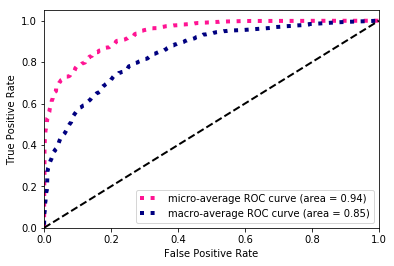

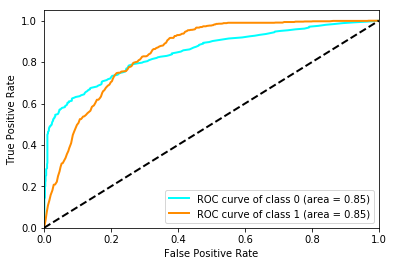

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.908939     0.470731     0.689835     0.844613      0.851235
precision     0.925329     0.426794     0.676061     0.844613      0.859681
recall        0.893120     0.524752     0.708936     0.844613      0.844613
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.846211     0.846211     0.846340     0.937085           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 100)
(41184, 2)
(8437, 100)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               51712     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)         

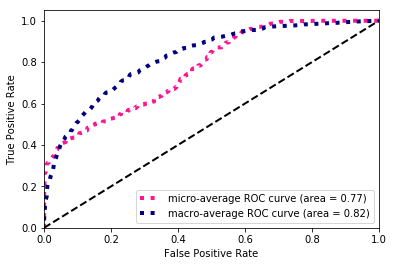

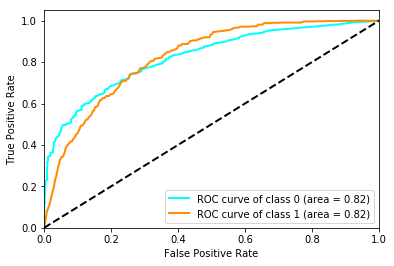

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.752437     0.390314     0.571376     0.647861      0.704752
precision     0.965775     0.252791     0.609283     0.647861      0.871888
recall        0.616298     0.855986     0.736142     0.647861      0.647861
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.823266     0.823266     0.823424     0.771782           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 100)
(41184, 2)
(8437, 100)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               51712     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)         

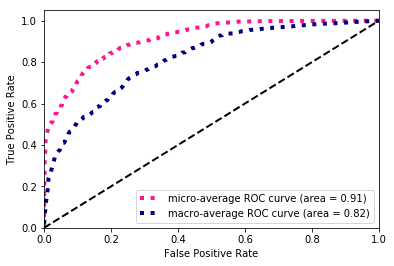

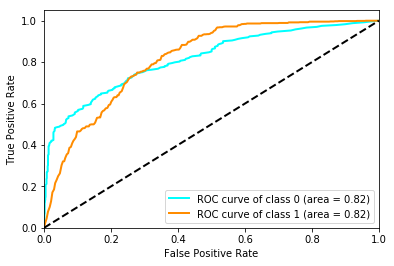

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.893841     0.417979     0.655910     0.820434      0.831178
precision     0.918359     0.364611     0.641485     0.820434      0.845440
recall        0.870598     0.489649     0.680123     0.820434      0.820434
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.815495     0.815495     0.815688     0.911513           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 14)
(41184, 2)
(8437, 14)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               7680      
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)           

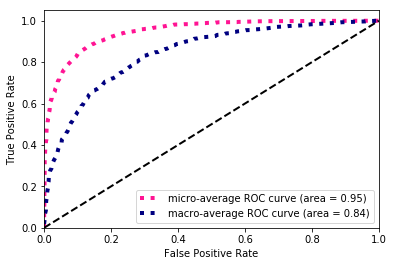

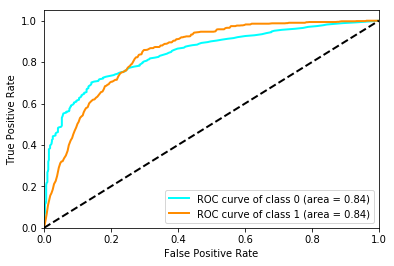

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.930573     0.243834     0.587203     0.872822      0.840142
precision     0.884611     0.561688     0.723149     0.872822      0.842088
recall        0.981572     0.155716     0.568644     0.872822      0.872822
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.843306     0.843306     0.843467     0.946518           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 14)
(41184, 2)
(8437, 14)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               7680      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)           

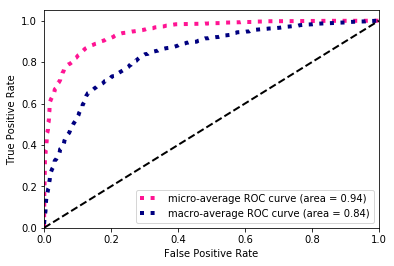

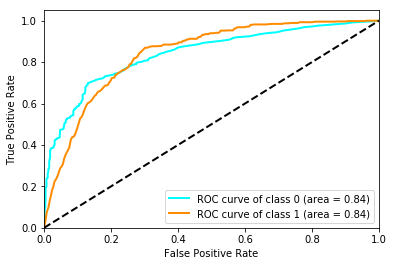

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.929525     0.242340     0.585932     0.871044      0.839035
precision     0.884492     0.535385     0.709938     0.871044      0.838521
recall        0.979388     0.156616     0.568002     0.871044      0.871044
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.840644     0.840644     0.840816     0.944953           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 14)
(41184, 2)
(8437, 14)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               7680      
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)           

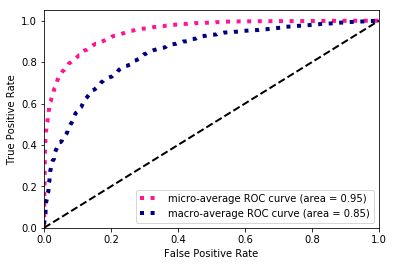

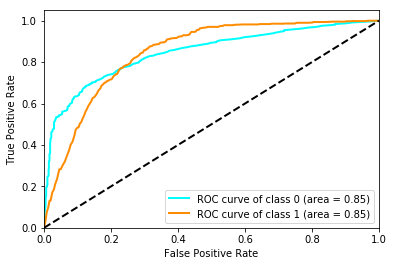

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.926721     0.295597     0.611159     0.867251      0.843613
precision     0.889922     0.490605     0.690264     0.867251      0.837339
recall        0.966694     0.211521     0.589108     0.867251      0.867251
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.846787     0.846787     0.846920     0.947002           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 64)
(41184, 2)
(8437, 64)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               33280     
_________________________________________________________________
dense_26 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)           

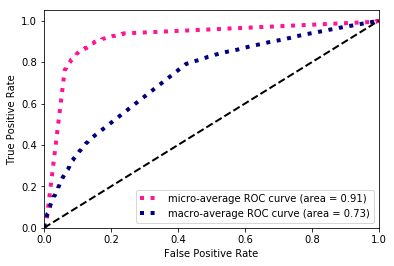

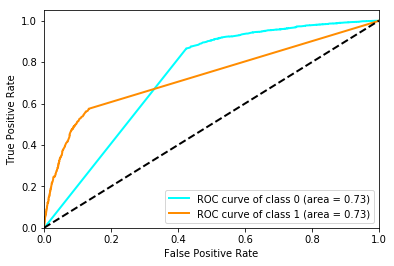

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.928364     0.366394     0.647379     0.871281      0.854363
precision     0.898264     0.520730     0.709497     0.871281      0.848550
recall        0.960551     0.282628     0.621590     0.871281      0.871281
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.732226     0.732226     0.732354     0.913864           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 64)
(41184, 2)
(8437, 64)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               33280     
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_15 (Batc (None, 256)               1024      
_________________________________________________________________
activation_15 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)           

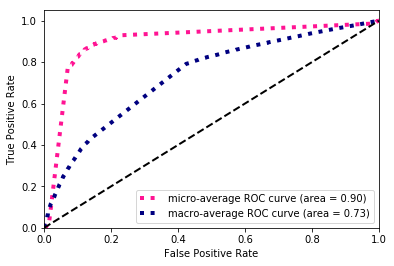

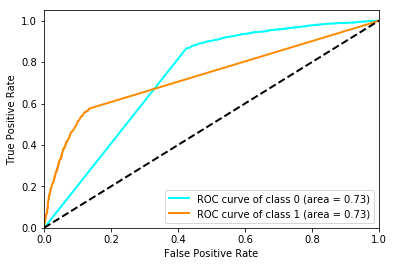

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.926010     0.407051     0.666531     0.868437      0.857672
precision     0.904898     0.500657     0.702778     0.868437      0.851667
recall        0.948130     0.342934     0.645532     0.868437      0.868437
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.731962     0.731962     0.732037     0.899625           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 64)
(41184, 2)
(8437, 64)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               33280     
_________________________________________________________________
dense_34 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)           

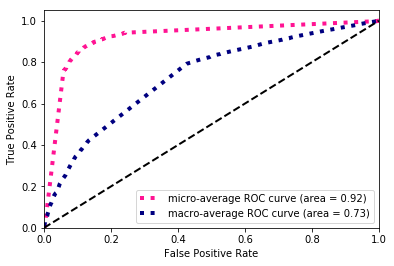

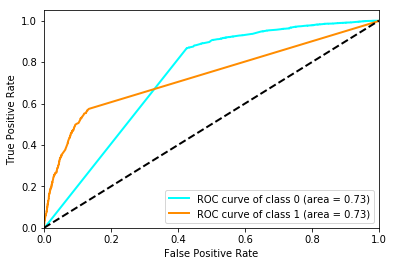

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.931585     0.319273     0.625429     0.875667      0.850955
precision     0.891970     0.572093     0.732031     0.875667      0.849848
recall        0.974884     0.221422     0.598153     0.875667      0.875667
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.731095     0.731095     0.731189     0.918929           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 80)
(41184, 2)
(8437, 80)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               41472     
_________________________________________________________________
dense_38 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_19 (Batc (None, 256)               1024      
_________________________________________________________________
activation_19 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)           

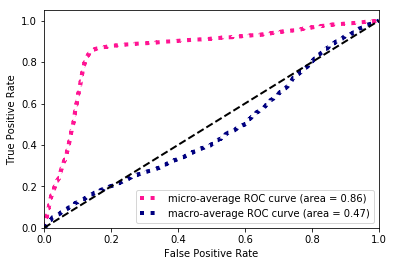

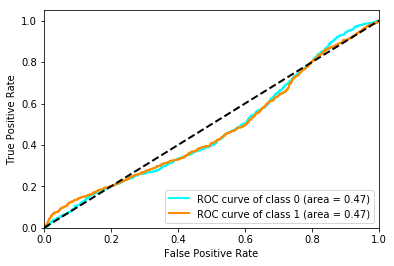

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.921729     0.100666     0.511198     0.855991      0.813610
precision     0.872758     0.283333     0.578046     0.855991      0.795142
recall        0.976522     0.061206     0.518864     0.855991      0.855991
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.472402     0.472403     0.472533     0.858963           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 80)
(41184, 2)
(8437, 80)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 512)               41472     
_________________________________________________________________
dense_42 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_21 (Batc (None, 256)               1024      
_________________________________________________________________
activation_21 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)           

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


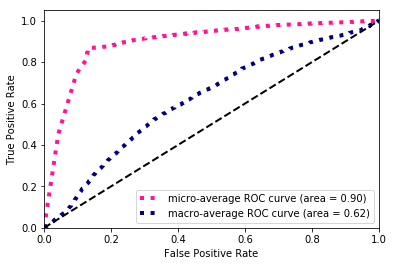

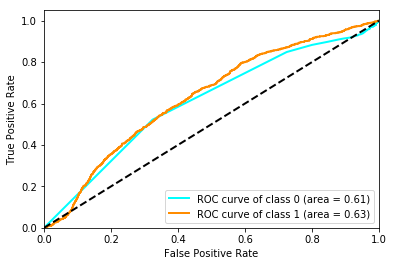

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.929518     0.000000     0.464759     0.868318      0.807118
precision     0.868318     0.000000     0.434159     0.868318      0.753976
recall        1.000000     0.000000     0.500000     0.868318      0.868318
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.608990     0.630312     0.619744     0.895680           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 80)
(41184, 2)
(8437, 80)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)               41472     
_________________________________________________________________
dense_46 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_23 (Batc (None, 256)               1024      
_________________________________________________________________
activation_23 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)           

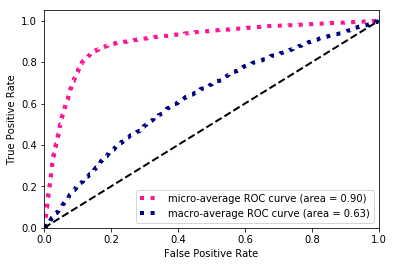

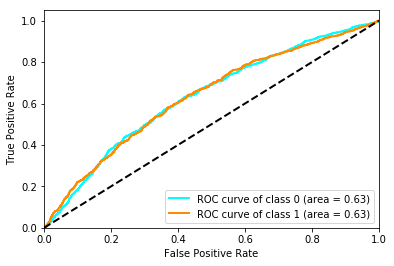

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.919206     0.117314     0.518260     0.851962      0.813611
precision     0.873601     0.273026     0.573314     0.851962      0.794517
recall        0.969833     0.074707     0.522270     0.851962      0.851962
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.633063     0.633063     0.633192     0.896381           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 56)
(41184, 2)
(8437, 56)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               29184     
_________________________________________________________________
dense_50 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
activation_25 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)           

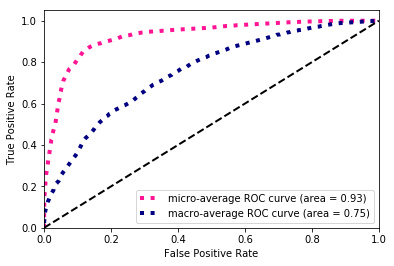

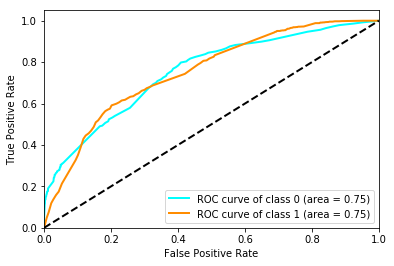

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.929518     0.000000     0.464759     0.868318      0.807118
precision     0.868318     0.000000     0.434159     0.868318      0.753976
recall        1.000000     0.000000     0.500000     0.868318      0.868318
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.752614     0.752614     0.752643     0.926087           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 56)
(41184, 2)
(8437, 56)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 512)               29184     
_________________________________________________________________
dense_54 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_27 (Batc (None, 256)               1024      
_________________________________________________________________
activation_27 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)           

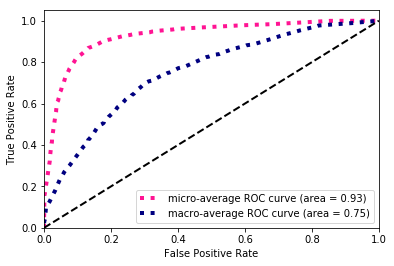

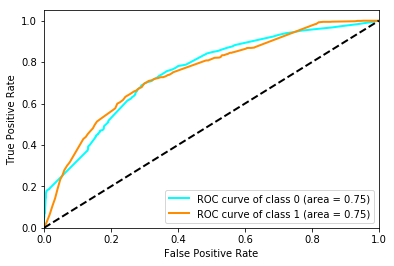

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.929518     0.000000     0.464759     0.868318      0.807118
precision     0.868318     0.000000     0.434159     0.868318      0.753976
recall        1.000000     0.000000     0.500000     0.868318      0.868318
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.751183     0.751183     0.751222     0.925759           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 56)
(41184, 2)
(8437, 56)
(8437, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_57 (Dense)             (None, 512)               29184     
_________________________________________________________________
dense_58 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_29 (Batc (None, 256)               1024      
_________________________________________________________________
activation_29 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)           

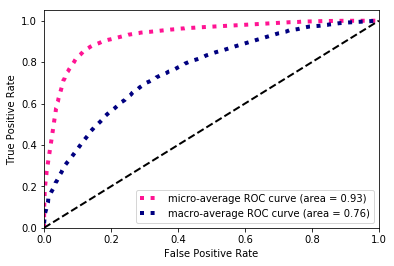

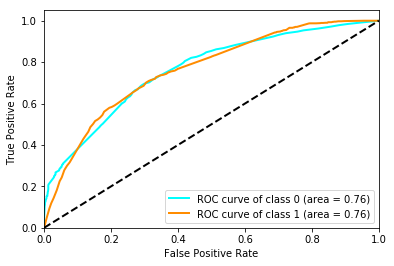

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.928759     0.088307     0.508533     0.867844      0.818086
precision     0.873033     0.482143     0.677588     0.867844      0.821560
recall        0.992083     0.048605     0.520344     0.867844      0.867844
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.762186     0.762186     0.762222     0.928269           NaN

In [12]:
Houston = compare_models(city='Houston',classname='DNN')

In [13]:
Houston.to_hdf('Houston.h5',key='DNN_only')
Houston

NL   geohash   traffic   weather      time
0_f1-score              0.851739  0.928939  0.928653  0.923484  0.929265
1_f1-score              0.426341  0.260590  0.364240  0.072660  0.029436
weighted avg_f1-score   0.795722  0.840930  0.854330  0.811446  0.810774
micro avg_f1-score      0.770969  0.870373  0.871795  0.858757  0.868160
macro avg_f1-score      0.639040  0.594765  0.646446  0.498072  0.479350
0_precision             0.936488  0.886342  0.898377  0.871559  0.869890
1_precision             0.348065  0.529226  0.531160  0.185453  0.160714
weighted avg_precision  0.859003  0.839316  0.850021  0.781212  0.776504
micro avg_precision     0.770969  0.870373  0.871795  0.858757  0.868160
macro avg_precision     0.642276  0.707784  0.714769  0.528506  0.515302
0_recall                0.793339  0.975885  0.961188  0.982118  0.997361
1_recall                0.623462  0.174617  0.282328  0.045305  0.016202
weighted avg_recall     0.770969  0.870373  0.871795  0.858757  0.868160
micro avg_recall        0.770969  0.870373  0.871795  0.858757  0.868160
macro avg_recall        0.708401  0.575251  0.621758  0.513712  0.506781
0_auc                   0.828324  0.843579  0.731761  0.571485  0.755328
1_auc                   0.828324  0.843579  0.731761  0.578593  0.755328
micro avg_auc           0.873460  0.946158  0.910806  0.883675  0.926705
macro avg_auc           0.828484  0.843734  0.731860  0.575156  0.755362

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 178)
(41184, 2)
(8437, 178)
(8437, 2)
(41184, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 8, 128)            70144     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_61 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_62 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

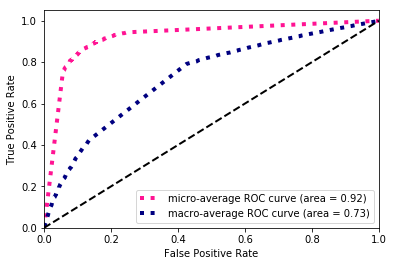

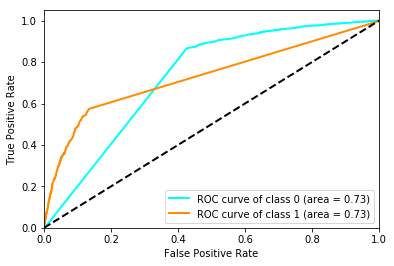

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.929428     0.332300     0.630864     0.872348      0.850797
precision     0.893762     0.533865     0.713813     0.872348      0.846370
recall        0.968059     0.241224     0.604642     0.872348      0.872348
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.729082     0.729082     0.729155     0.920788           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 178)
(41184, 2)
(8437, 178)
(8437, 2)
(41184, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8, 128)            70144     
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_65 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_66 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

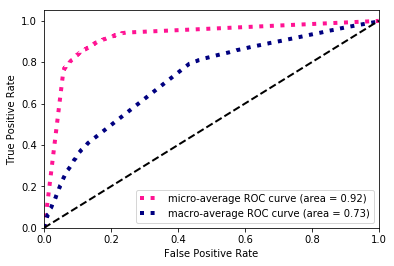

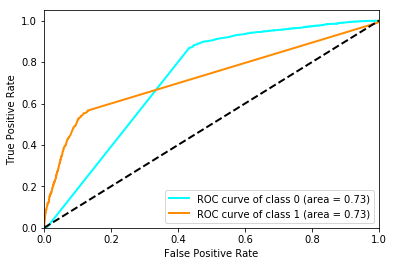

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.927058     0.359420     0.643239     0.869029      0.852310
precision     0.897610     0.504886     0.701248     0.869029      0.845895
recall        0.958504     0.279028     0.618766     0.869029      0.869029
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.725343     0.725343     0.725389     0.919148           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 178)
(41184, 2)
(8437, 178)
(8437, 2)
(41184, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 8, 128)            70144     
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_69 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_70 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

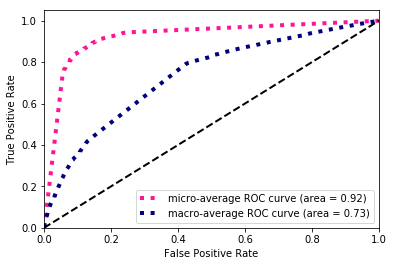

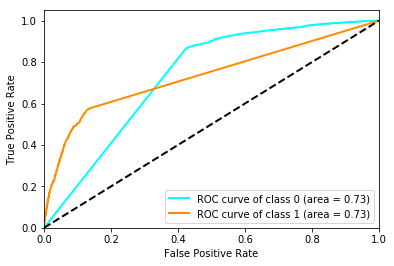

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.929579     0.344533     0.637056     0.872822      0.852539
precision     0.895209     0.536122     0.715665     0.872822      0.847924
recall        0.966694     0.253825     0.610260     0.872822      0.872822
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.733017     0.733017     0.733127     0.920969           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 194)
(41184, 2)
(8437, 194)
(8437, 2)
(41184, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 8, 128)            71168     
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_73 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_74 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizat

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


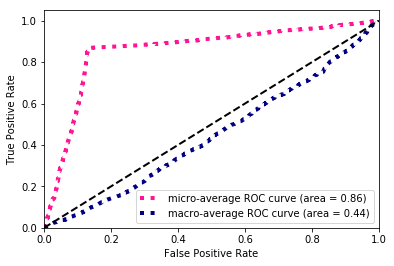

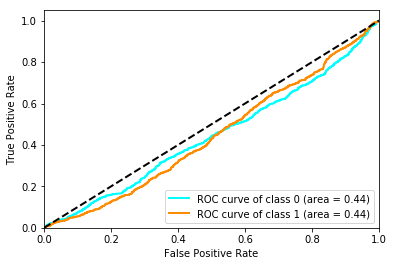

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.929518     0.000000     0.464759     0.868318      0.807118
precision     0.868318     0.000000     0.434159     0.868318      0.753976
recall        1.000000     0.000000     0.500000     0.868318      0.868318
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.444739     0.444739     0.444864     0.855681           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 194)
(41184, 2)
(8437, 194)
(8437, 2)
(41184, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 8, 128)            71168     
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_77 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_78 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizat

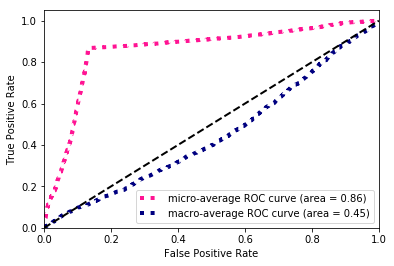

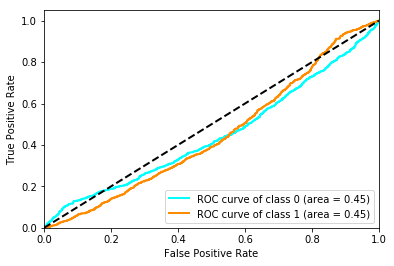

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.929518     0.000000     0.464759     0.868318      0.807118
precision     0.868318     0.000000     0.434159     0.868318      0.753976
recall        1.000000     0.000000     0.500000     0.868318      0.868318
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.447676     0.447676     0.447803     0.856353           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 194)
(41184, 2)
(8437, 194)
(8437, 2)
(41184, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_81 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_82 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizat

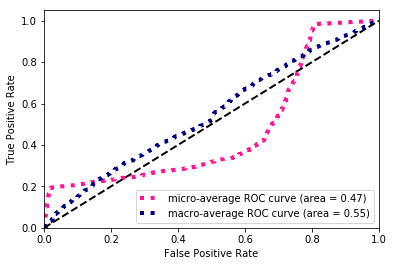

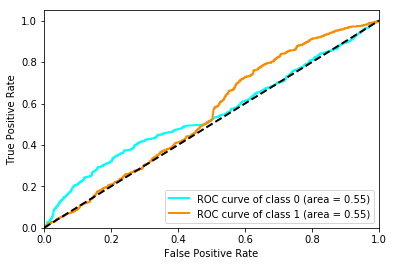

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.471280     0.254748     0.363014     0.381415      0.442766
precision     0.913949     0.151392     0.532670     0.381415      0.813534
recall        0.317499     0.802880     0.560190     0.381415      0.381415
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.548676     0.548676     0.548780     0.470174           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 170)
(41184, 2)
(8437, 170)
(8437, 2)
(41184, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_85 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_86 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

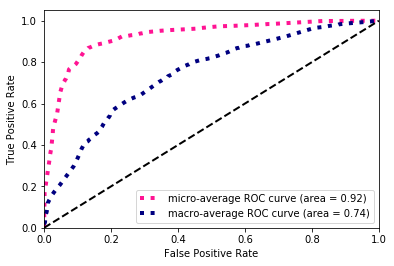

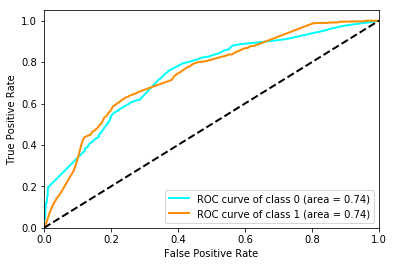

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.929518     0.000000     0.464759     0.868318      0.807118
precision     0.868318     0.000000     0.434159     0.868318      0.753976
recall        1.000000     0.000000     0.500000     0.868318      0.868318
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.742749     0.742749     0.742789     0.923831           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 170)
(41184, 2)
(8437, 170)
(8437, 2)
(41184, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_89 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_90 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

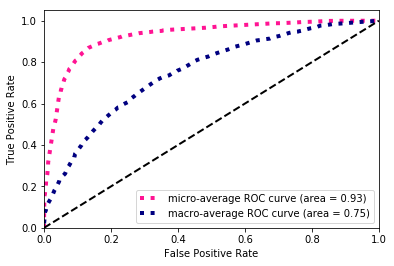

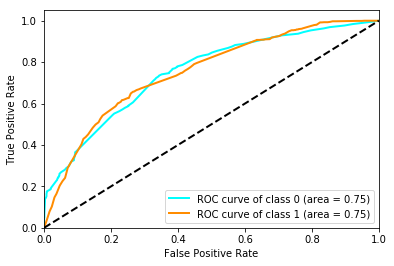

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.929518     0.000000     0.464759     0.868318      0.807118
precision     0.868318     0.000000     0.434159     0.868318      0.753976
recall        1.000000     0.000000     0.500000     0.868318      0.868318
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.752118     0.752118     0.752165     0.925973           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 170)
(41184, 2)
(8437, 170)
(8437, 2)
(41184, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_93 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_94 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalizati

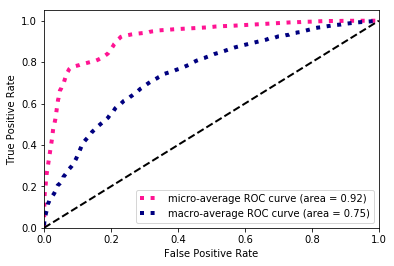

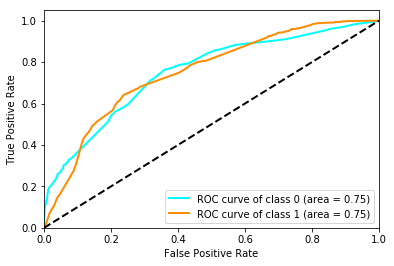

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.898898     0.347903     0.623400     0.824938      0.826342
precision     0.901552     0.341421     0.621486     0.824938      0.827793
recall        0.896260     0.354635     0.625448     0.824938      0.824938
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.750660     0.750660     0.750711     0.919066           NaN

In [14]:
Houston = compare_models(city='Houston',classname='RNN')

In [15]:
Houston.to_hdf('Houston.h5',key='RNN_only')
Houston

traffic   weather      time
0_f1-score              0.928688  0.776772  0.919312
1_f1-score              0.345418  0.084916  0.115968
weighted avg_f1-score   0.851882  0.685667  0.813526
micro avg_f1-score      0.871400  0.706017  0.853858
macro avg_f1-score      0.637053  0.430844  0.517640
0_precision             0.895527  0.883528  0.879396
1_precision             0.524957  0.050464  0.113807
weighted avg_precision  0.846730  0.773829  0.778582
micro avg_precision     0.871400  0.706017  0.853858
macro avg_precision     0.710242  0.466996  0.496601
0_recall                0.964419  0.772500  0.965420
1_recall                0.258026  0.267627  0.118212
weighted avg_recall     0.871400  0.706017  0.853858
micro avg_recall        0.871400  0.706017  0.853858
macro avg_recall        0.611222  0.520063  0.541816
0_auc                   0.729147  0.480364  0.748509
1_auc                   0.729147  0.480364  0.748509
micro avg_auc           0.920302  0.727402  0.922957
macro avg_auc           0.729224  0.480482  0.748555

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 179)
(41184, 2)
(8437, 179)
(8437, 2)
(41184, 8, 8)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

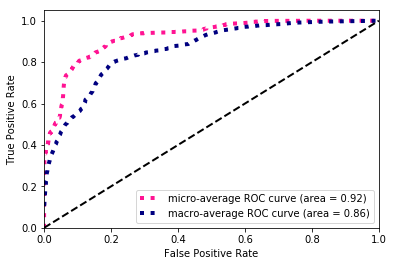

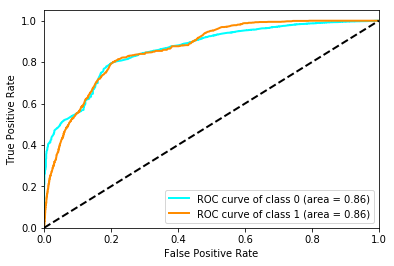

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.909193     0.501922     0.705557     0.846391      0.855563
precision     0.934063     0.437961     0.686012     0.846391      0.868735
recall        0.885613     0.587759     0.736686     0.846391      0.846391
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.861328     0.861328     0.861434     0.923850           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 179)
(41184, 2)
(8437, 179)
(8437, 2)
(41184, 8, 8)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

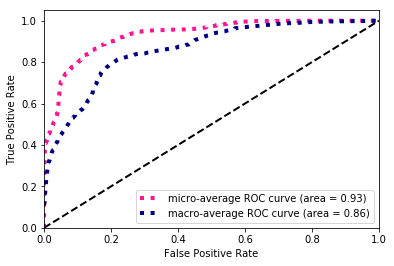

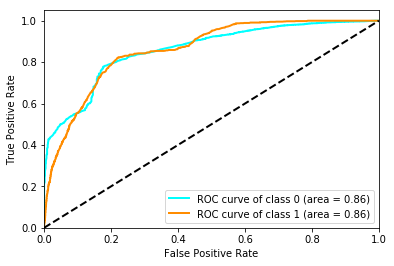

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.917058     0.501247     0.709153     0.857769      0.862304
precision     0.928871     0.465637     0.697254     0.857769      0.867872
recall        0.905542     0.542754     0.724148     0.857769      0.857769
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.860012     0.860010     0.860097     0.931430           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 179)
(41184, 2)
(8437, 179)
(8437, 2)
(41184, 8, 8)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

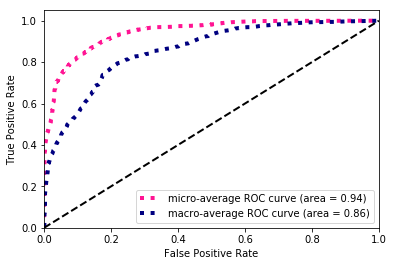

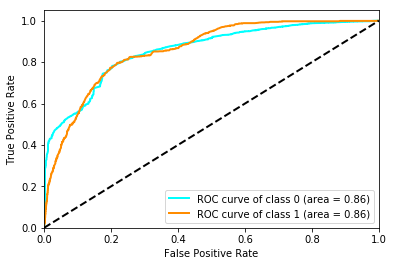

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.920285     0.487676     0.703980     0.862036      0.863318
precision     0.923447     0.477175     0.700311     0.862036      0.864681
recall        0.917144     0.498650     0.707897     0.862036      0.862036
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.857019     0.857019     0.857120     0.942813           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 195)
(41184, 2)
(8437, 195)
(8437, 2)
(41184, 8, 10)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

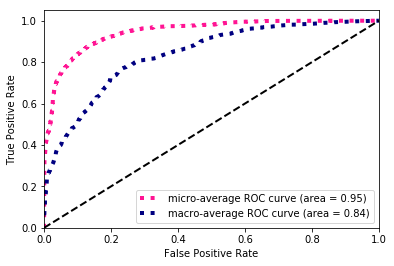

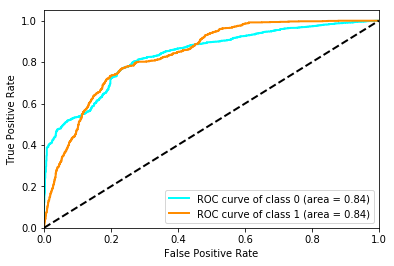

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.928609     0.370198     0.649404     0.871755      0.855076
precision     0.898723     0.523888     0.711305     0.871755      0.849364
recall        0.960551     0.286229     0.623390     0.871755      0.871755
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.835854     0.835854     0.836050     0.945127           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 195)
(41184, 2)
(8437, 195)
(8437, 2)
(41184, 8, 10)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

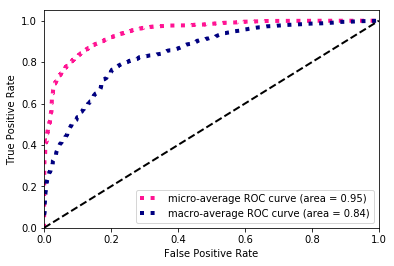

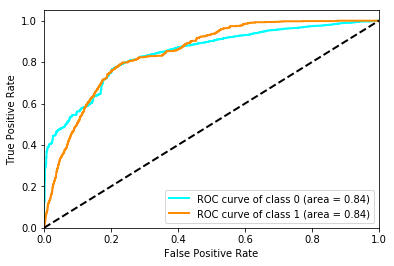

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.925859     0.411858     0.668859     0.868318      0.858175
precision     0.905732     0.500000     0.702866     0.868318      0.852304
recall        0.946901     0.350135     0.648518     0.868318      0.868318
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.844197     0.844197     0.844389     0.945564           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 195)
(41184, 2)
(8437, 195)
(8437, 2)
(41184, 8, 10)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

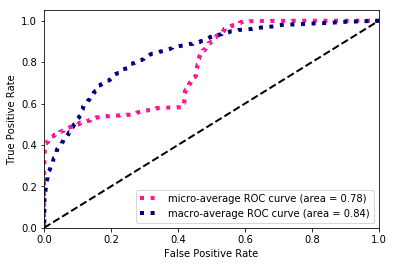

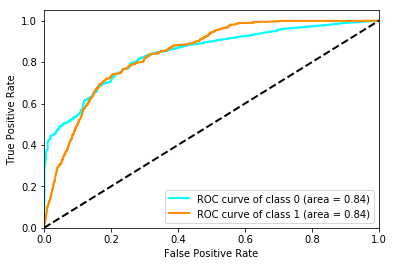

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.690178     0.364787     0.527482     0.583501      0.647330
precision     0.974602     0.228229     0.601415     0.583501      0.876318
recall        0.534262     0.908191     0.721226     0.583501      0.583501
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.842484     0.842493     0.842676     0.781104           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(41184, 171)
(41184, 2)
(8437, 171)
(8437, 2)
(41184, 8, 7)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

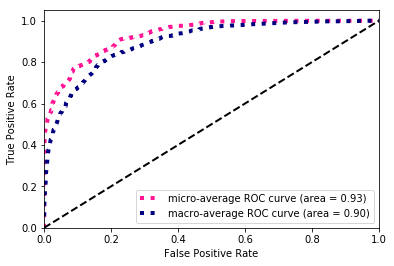

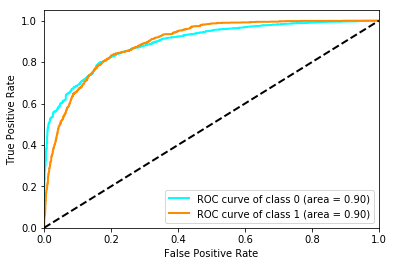

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.900876     0.553053     0.726964     0.837739      0.855074
precision     0.959291     0.433914     0.696602     0.837739      0.890108
recall        0.849167     0.762376     0.805772     0.837739      0.837739
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.895338     0.895338     0.895405     0.932404           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(41184, 171)
(41184, 2)
(8437, 171)
(8437, 2)
(41184, 8, 7)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

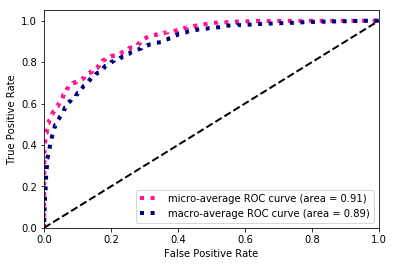

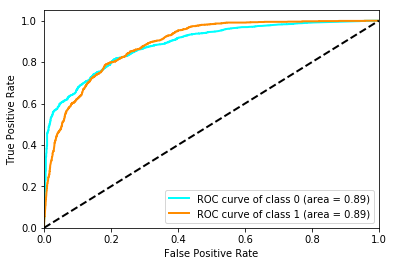

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.885786     0.524480     0.705133     0.815811      0.838208
precision     0.959554     0.397311     0.678433     0.815811      0.885517
recall        0.822550     0.771377     0.796963     0.815811      0.815811
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.887212     0.887212     0.887288     0.913503           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(41184, 171)
(41184, 2)
(8437, 171)
(8437, 2)
(41184, 8, 7)
(41184,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

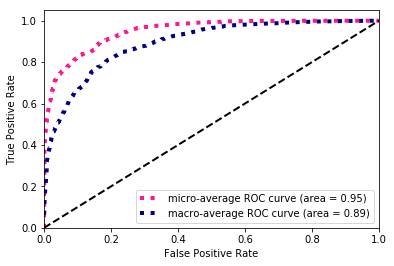

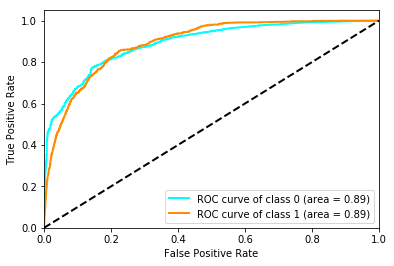

0            1    macro avg    micro avg  weighted avg
index                                                                      
f1-score      0.913551     0.551522     0.732536     0.855043      0.865878
precision     0.947368     0.465347     0.706357     0.855043      0.883895
recall        0.882064     0.676868     0.779466     0.855043      0.855043
support    7326.000000  1111.000000  8437.000000  8437.000000   8437.000000
auc           0.891303     0.891303     0.891374     0.948496           NaN

In [16]:
Houston = compare_models(city='Houston',classname='RNN_embed')

In [17]:
Houston.to_hdf('Houston.h5',key='RNN_embed_only')
Houston

traffic   weather      time
0_f1-score              0.915512  0.848215  0.900071
1_f1-score              0.496948  0.382281  0.543018
weighted avg_f1-score   0.860395  0.786860  0.853053
micro avg_f1-score      0.855399  0.774525  0.836198
macro avg_f1-score      0.706230  0.615248  0.721544
0_precision             0.928794  0.926352  0.955404
1_precision             0.460258  0.417372  0.432191
weighted avg_precision  0.867096  0.859329  0.886507
micro avg_precision     0.855399  0.774525  0.836198
macro avg_precision     0.694526  0.671862  0.693797
0_recall                0.902766  0.813905  0.851260
1_recall                0.543054  0.514851  0.736874
weighted avg_recall     0.855399  0.774525  0.836198
micro avg_recall        0.855399  0.774525  0.836198
macro avg_recall        0.722910  0.664378  0.794067
0_auc                   0.859453  0.840845  0.891284
1_auc                   0.859452  0.840848  0.891284
micro avg_auc           0.932698  0.890599  0.931468
macro avg_auc           0.859551  0.841038  0.891356

# Charlotte

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 100)
(21102, 2)
(4385, 100)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_142 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_143 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_67 (Batc (None, 256)               1024      
_________________________________________________________________
activation_67 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)         

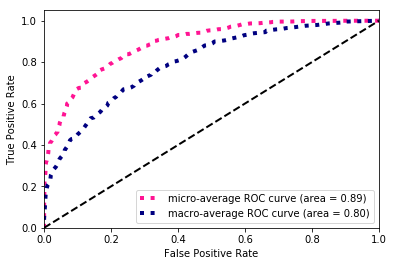

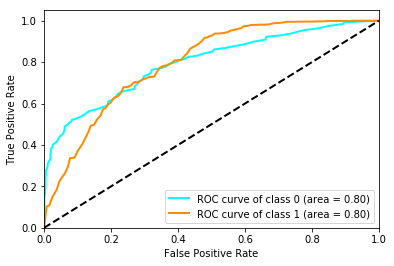

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.879698    0.337045     0.608372     0.796351      0.763495
precision     0.820971    0.556373     0.688672     0.796351      0.764310
recall        0.947475    0.241747     0.594611     0.796351      0.796351
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.796184    0.796184     0.796252     0.887391           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 100)
(21102, 2)
(4385, 100)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_146 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_147 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_69 (Batc (None, 256)               1024      
_________________________________________________________________
activation_69 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)         

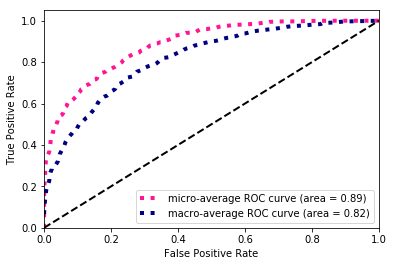

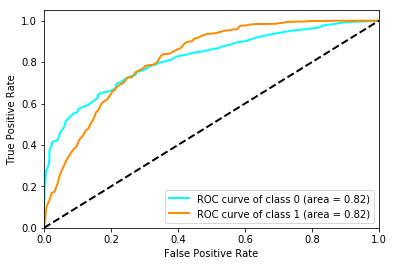

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.859631    0.523308     0.691470     0.783124      0.787611
precision     0.874737    0.494318     0.684528     0.783124      0.793275
recall        0.845038    0.555911     0.700474     0.783124      0.783124
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.816209    0.816209     0.816265     0.885235           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 100)
(21102, 2)
(4385, 100)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_151 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_71 (Batc (None, 256)               1024      
_________________________________________________________________
activation_71 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)         

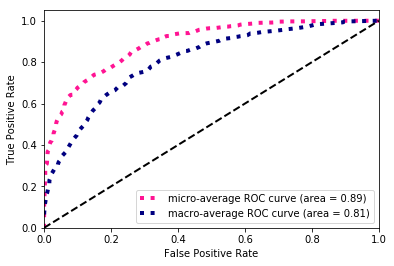

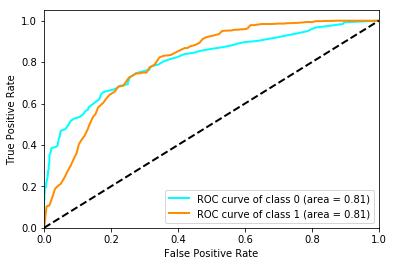

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.870771    0.401797     0.636284     0.787457      0.770345
precision     0.833776    0.505654     0.669715     0.787457      0.763512
recall        0.911201    0.333333     0.622267     0.787457      0.787457
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.807487    0.807487     0.807564     0.890531           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 14)
(21102, 2)
(4385, 14)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_154 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_155 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_73 (Batc (None, 256)               1024      
_________________________________________________________________
activation_73 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_37 (Dropout)         (None, 256)           

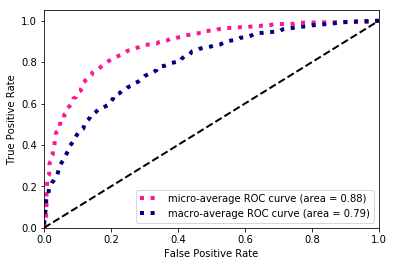

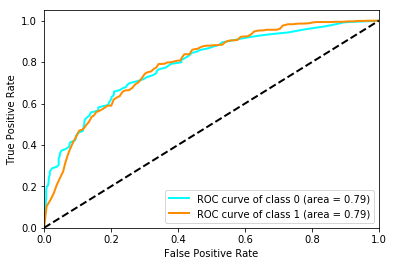

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.882165    0.457508     0.669837     0.806385      0.791229
precision     0.845438    0.571885     0.708661     0.806385      0.786859
recall        0.922229    0.381257     0.651743     0.806385      0.806385
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.791926    0.791926     0.792105     0.880019           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 14)
(21102, 2)
(4385, 14)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_158 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_159 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_75 (Batc (None, 256)               1024      
_________________________________________________________________
activation_75 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)           

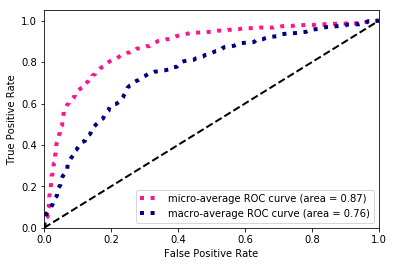

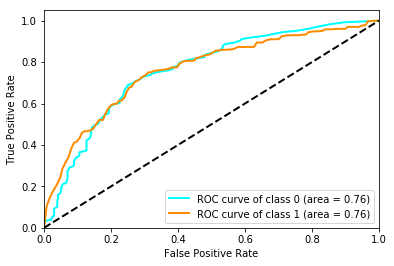

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.880556    0.452229     0.666392     0.803877      0.788834
precision     0.844433    0.562599     0.703516     0.803877      0.784081
recall        0.919907    0.378062     0.648984     0.803877      0.803877
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.761704    0.761704     0.761928     0.871884           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 14)
(21102, 2)
(4385, 14)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_162 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_163 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_77 (Batc (None, 256)               1024      
_________________________________________________________________
activation_77 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 256)           

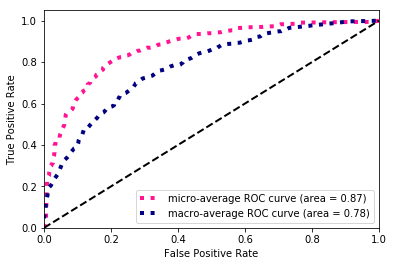

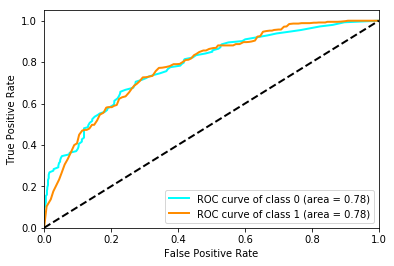

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.878901    0.440743     0.659822     0.800912      0.785075
precision     0.841881    0.553055     0.697468     0.800912      0.780032
recall        0.919327    0.366347     0.642837     0.800912      0.800912
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.779756    0.779756     0.779945     0.869698           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 64)
(21102, 2)
(4385, 64)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_166 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_167 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_79 (Batc (None, 256)               1024      
_________________________________________________________________
activation_79 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 256)           

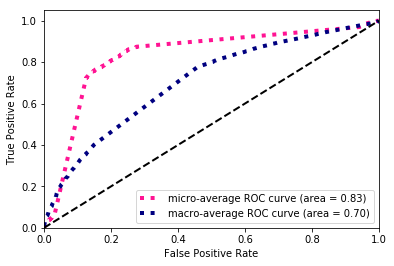

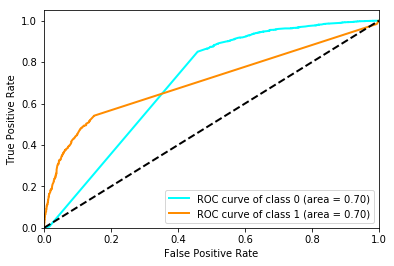

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.876888    0.506849     0.691869     0.802965      0.797648
precision     0.861422    0.546125     0.703774     0.802965      0.793905
recall        0.892919    0.472843     0.682881     0.802965      0.802965
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.704836    0.704900     0.704974     0.830946           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 64)
(21102, 2)
(4385, 64)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_170 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_171 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_81 (Batc (None, 256)               1024      
_________________________________________________________________
activation_81 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 256)           

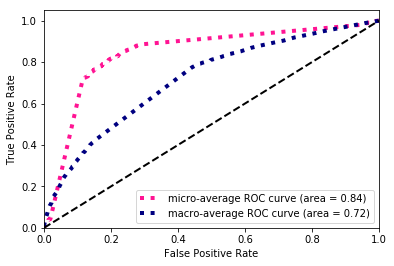

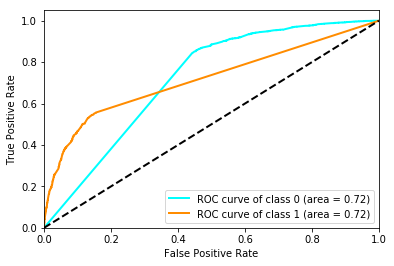

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.880646    0.506151     0.693398     0.807754      0.800452
precision     0.859829    0.562500     0.711164     0.807754      0.796159
recall        0.902496    0.460064     0.681280     0.807754      0.807754
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.716776    0.716776     0.716895     0.844325           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 64)
(21102, 2)
(4385, 64)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_174 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_175 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_83 (Batc (None, 256)               1024      
_________________________________________________________________
activation_83 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 256)           

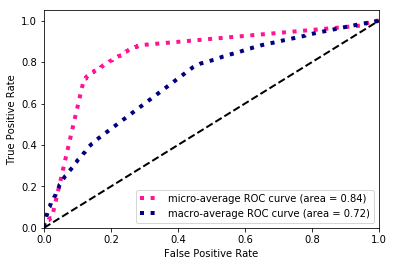

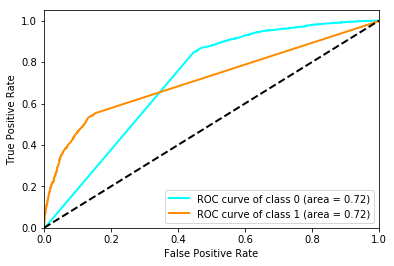

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.877388    0.510251     0.693819     0.803877      0.798770
precision     0.862388    0.548348     0.705368     0.803877      0.795140
recall        0.892919    0.477103     0.685011     0.803877      0.803877
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.715042    0.715106     0.715152     0.838709           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 80)
(21102, 2)
(4385, 80)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_178 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_179 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_85 (Batc (None, 256)               1024      
_________________________________________________________________
activation_85 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 256)           

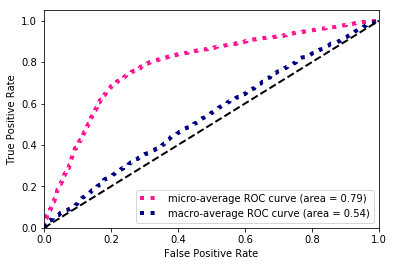

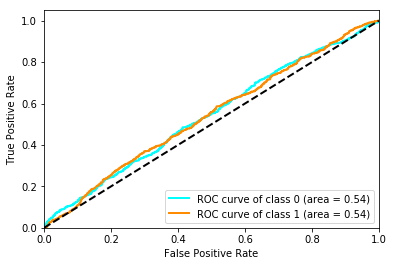

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.851098    0.108367     0.479732     0.744812      0.692050
precision     0.785942    0.215190     0.500566     0.744812      0.663722
recall        0.928033    0.072417     0.500225     0.744812      0.744812
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.541038    0.541039     0.541238     0.786228           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 80)
(21102, 2)
(4385, 80)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_182 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_183 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_87 (Batc (None, 256)               1024      
_________________________________________________________________
activation_87 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 256)           

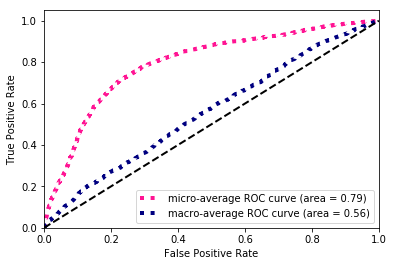

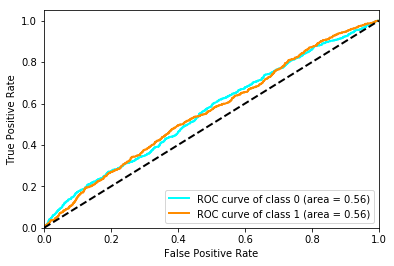

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.846320    0.175617     0.510969     0.740935      0.702696
precision     0.792701    0.275626     0.534164     0.740935      0.681975
recall        0.907719    0.128860     0.518290     0.740935      0.740935
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.559466    0.559466     0.559669     0.793394           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 80)
(21102, 2)
(4385, 80)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_186 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_187 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_89 (Batc (None, 256)               1024      
_________________________________________________________________
activation_89 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)           

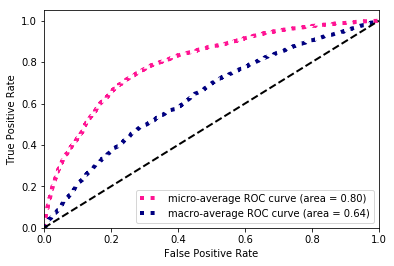

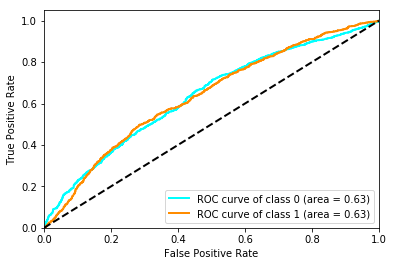

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.834677    0.311948     0.573313     0.733409      0.722740
precision     0.814069    0.348684     0.581377     0.733409      0.714412
recall        0.856355    0.282215     0.569285     0.733409      0.733409
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.634906    0.634906     0.635107     0.797558           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 56)
(21102, 2)
(4385, 56)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_190 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_191 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_91 (Batc (None, 256)               1024      
_________________________________________________________________
activation_91 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 256)           

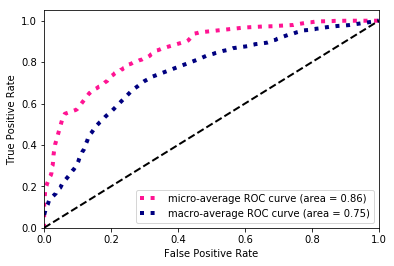

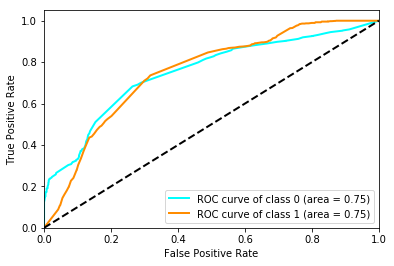

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.850755    0.453773     0.652264     0.765564      0.765745
precision     0.851249    0.452810     0.652030     0.765564      0.765928
recall        0.850261    0.454739     0.652500     0.765564      0.765564
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.750326    0.750326     0.750372     0.857380           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 56)
(21102, 2)
(4385, 56)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_194 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_195 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_93 (Batc (None, 256)               1024      
_________________________________________________________________
activation_93 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_47 (Dropout)         (None, 256)           

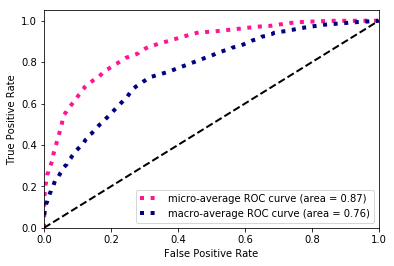

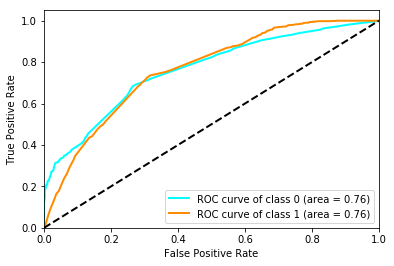

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.872822    0.374072     0.623447     0.788597      0.766020
precision     0.827739    0.511070     0.669404     0.788597      0.759928
recall        0.923099    0.294995     0.609047     0.788597      0.788597
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.762189    0.762189     0.762277     0.873344           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 56)
(21102, 2)
(4385, 56)
(4385, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_198 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_199 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_95 (Batc (None, 256)               1024      
_________________________________________________________________
activation_95 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 256)           

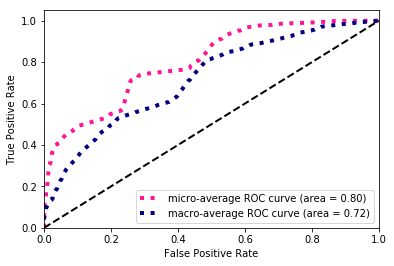

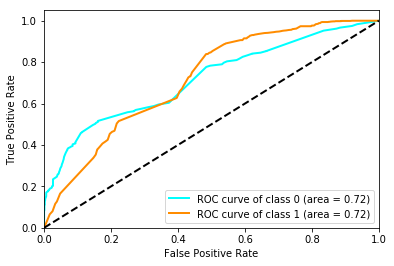

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.816382    0.418251     0.617316     0.720867      0.731126
precision     0.845031    0.377682     0.611357     0.720867      0.744953
recall        0.789611    0.468584     0.629097     0.720867      0.720867
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.716570    0.716570     0.716633     0.800019           NaN

In [18]:
Charlotte = compare_models(city='Charlotte',classname='DNN')

In [19]:
Charlotte.to_hdf('Charlotte.h5',key='DNN_only')
Charlotte

NL   geohash   traffic   weather      time
0_f1-score              0.870033  0.880541  0.878307  0.844032  0.846653
1_f1-score              0.420717  0.450160  0.507750  0.198644  0.415365
weighted avg_f1-score   0.773817  0.788379  0.798957  0.705829  0.754297
micro avg_f1-score      0.788978  0.803725  0.804865  0.739719  0.758343
macro avg_f1-score      0.645375  0.665350  0.693029  0.521338  0.631009
0_precision             0.843161  0.843917  0.861213  0.797571  0.841340
1_precision             0.518782  0.562513  0.552324  0.279834  0.447188
weighted avg_precision  0.773699  0.783658  0.795068  0.686703  0.756936
micro avg_precision     0.788978  0.803725  0.804865  0.739719  0.758343
macro avg_precision     0.680971  0.703215  0.706769  0.538702  0.644264
0_recall                0.901238  0.920488  0.896111  0.897369  0.854324
1_recall                0.376997  0.375222  0.470004  0.161164  0.406106
weighted avg_recall     0.788978  0.803725  0.804865  0.739719  0.758343
micro avg_recall        0.788978  0.803725  0.804865  0.739719  0.758343
macro avg_recall        0.639117  0.647855  0.683057  0.529267  0.630215
0_auc                   0.806627  0.777795  0.712218  0.578470  0.743028
1_auc                   0.806627  0.777795  0.712261  0.578470  0.743028
micro avg_auc           0.887719  0.873867  0.837993  0.792394  0.843581
macro avg_auc           0.806694  0.777992  0.712340  0.578671  0.743094

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 178)
(21102, 2)
(4385, 178)
(4385, 2)
(21102, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_38 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_202 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_203 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

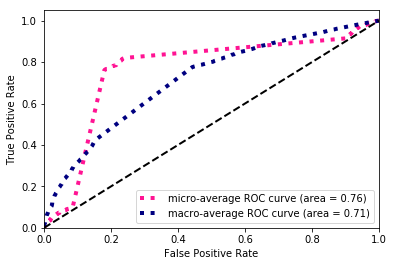

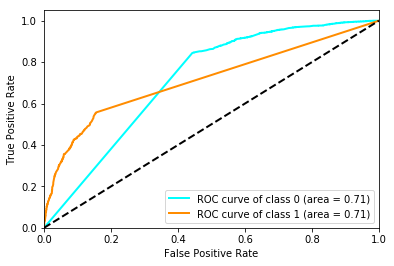

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.863234    0.497067     0.680150     0.784949      0.784823
precision     0.862859    0.497863     0.680361     0.784949      0.784699
recall        0.863610    0.496273     0.679941     0.784949      0.784949
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.713446    0.713511     0.713569     0.762820           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 178)
(21102, 2)
(4385, 178)
(4385, 2)
(21102, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_40 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_206 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_207 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

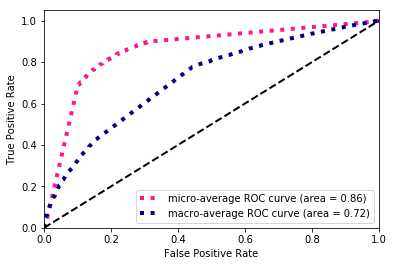

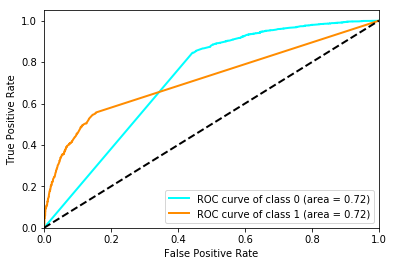

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.884084    0.480949     0.682517     0.810490      0.797757
precision     0.851195    0.581571     0.716383     0.810490      0.793458
recall        0.919617    0.410011     0.664814     0.810490      0.810490
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.716526    0.716526     0.716639     0.858704           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 178)
(21102, 2)
(4385, 178)
(4385, 2)
(21102, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_42 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_210 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_211 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

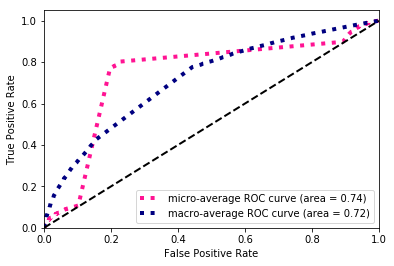

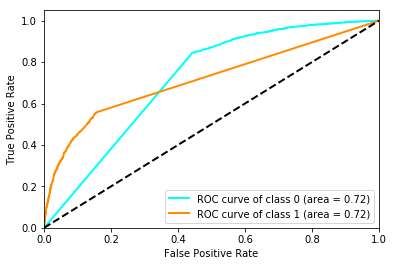

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.862251    0.516958     0.689604     0.785633      0.788310
precision     0.870930    0.499503     0.685217     0.785633      0.791393
recall        0.853743    0.535676     0.694710     0.785633      0.785633
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.715563    0.715499     0.715638     0.742348           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 194)
(21102, 2)
(4385, 194)
(4385, 2)
(21102, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_44 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_214 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_215 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


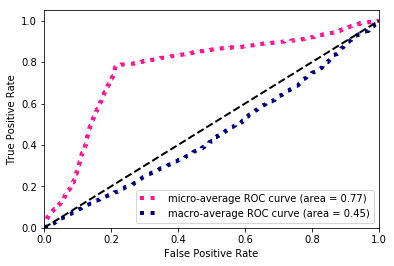

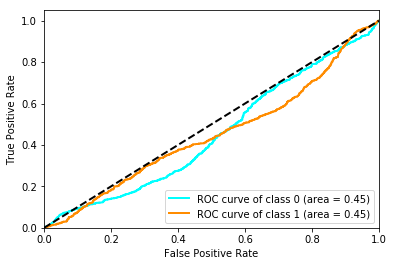

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.880092    0.000000     0.440046     0.785861      0.691630
precision     0.785861    0.000000     0.392930     0.785861      0.617577
recall        1.000000    0.000000     0.500000     0.785861      0.785861
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.451104    0.451104     0.451316     0.769404           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 194)
(21102, 2)
(4385, 194)
(4385, 2)
(21102, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_46 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_218 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_219 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

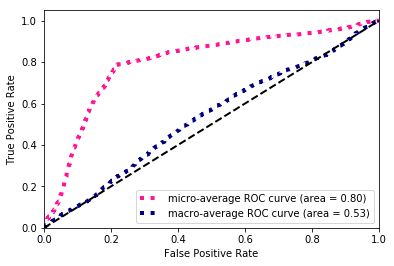

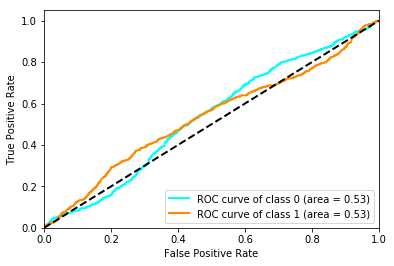

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.880092    0.000000     0.440046     0.785861      0.691630
precision     0.785861    0.000000     0.392930     0.785861      0.617577
recall        1.000000    0.000000     0.500000     0.785861      0.785861
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.532973    0.532968     0.533126     0.796958           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 194)
(21102, 2)
(4385, 194)
(4385, 2)
(21102, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_48 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_222 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_223 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

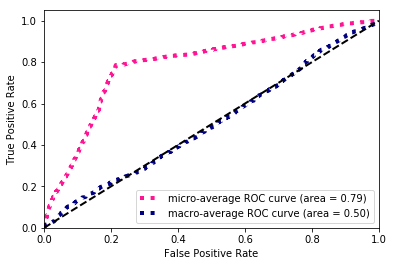

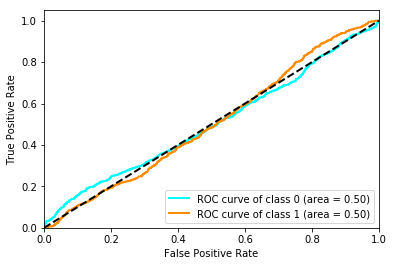

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.880092    0.000000     0.440046     0.785861      0.691630
precision     0.785861    0.000000     0.392930     0.785861      0.617577
recall        1.000000    0.000000     0.500000     0.785861      0.785861
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.504226    0.504228     0.504416     0.787283           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 170)
(21102, 2)
(4385, 170)
(4385, 2)
(21102, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_50 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_226 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_227 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

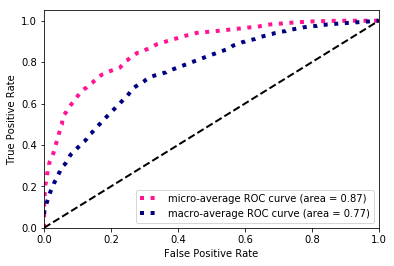

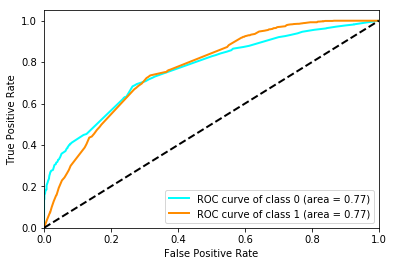

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.859129    0.423010     0.641069     0.773546      0.765739
precision     0.840411    0.465473     0.652942     0.773546      0.760122
recall        0.878700    0.387646     0.633173     0.773546      0.773546
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.765102    0.765099     0.765166     0.872482           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 170)
(21102, 2)
(4385, 170)
(4385, 2)
(21102, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_52 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_230 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_231 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

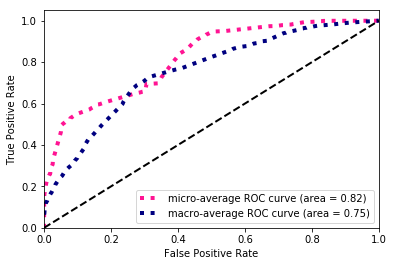

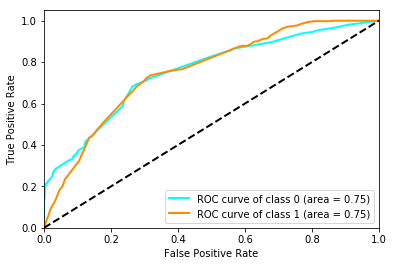

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.778237    0.507528     0.642883     0.694185      0.720268
precision     0.904652    0.387332     0.645992     0.694185      0.793874
recall        0.682821    0.735889     0.709355     0.694185      0.694185
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.753920    0.753920     0.753945     0.817696           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 170)
(21102, 2)
(4385, 170)
(4385, 2)
(21102, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_54 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_234 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_235 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

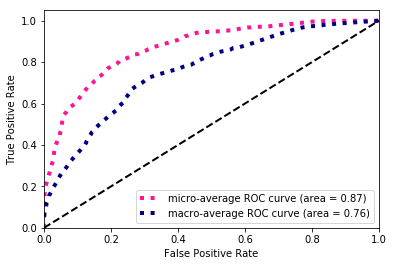

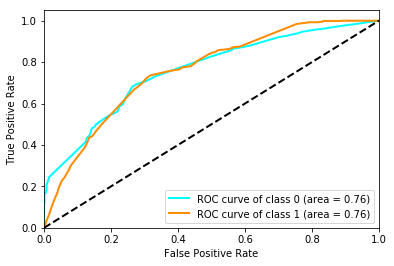

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.872063    0.376423     0.624243     0.787685      0.765927
precision     0.828243    0.507220     0.667732     0.787685      0.759500
recall        0.920778    0.299255     0.610016     0.787685      0.787685
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.758409    0.758409     0.758436     0.869777           NaN

In [20]:
Charlotte = compare_models(city='Charlotte',classname='RNN')

In [21]:
Charlotte.to_hdf('Charlotte.h5',key='RNN_only')
Charlotte

traffic   weather      time
0_f1-score              0.869856  0.880092  0.836476
1_f1-score              0.498325  0.000000  0.435654
weighted avg_f1-score   0.790297  0.691630  0.750645
micro avg_f1-score      0.793691  0.785861  0.751805
macro avg_f1-score      0.684091  0.440046  0.636065
0_precision             0.861661  0.785861  0.857769
1_precision             0.526313  0.000000  0.453342
weighted avg_precision  0.789850  0.617577  0.771165
micro avg_precision     0.793691  0.785861  0.751805
macro avg_precision     0.693987  0.392930  0.655555
0_recall                0.878990  1.000000  0.827433
1_recall                0.480653  0.000000  0.474263
weighted avg_recall     0.793691  0.785861  0.751805
micro avg_recall        0.793691  0.785861  0.751805
macro avg_recall        0.679822  0.500000  0.650848
0_auc                   0.715179  0.496101  0.759144
1_auc                   0.715179  0.496100  0.759143
micro avg_auc           0.787957  0.784548  0.853318
macro avg_auc           0.715282  0.496286  0.759183

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 179)
(21102, 2)
(4385, 179)
(4385, 2)
(21102, 8, 8)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

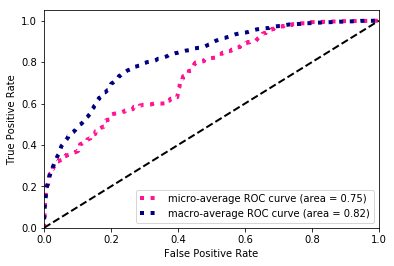

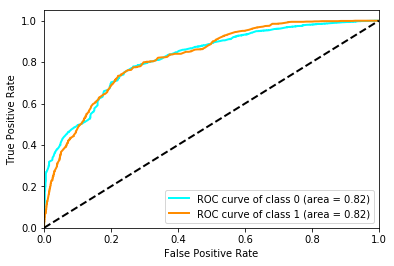

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.700272    0.492166     0.596219     0.623033      0.655708
precision     0.933301    0.345855     0.639578     0.623033      0.807506
recall        0.560360    0.853035     0.706697     0.623033      0.623033
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.823605    0.823605     0.823785     0.746784           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 179)
(21102, 2)
(4385, 179)
(4385, 2)
(21102, 8, 8)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

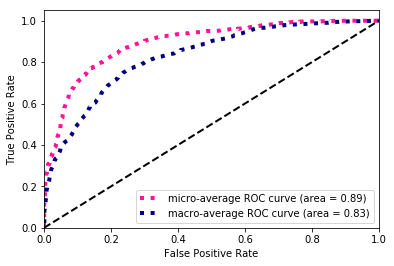

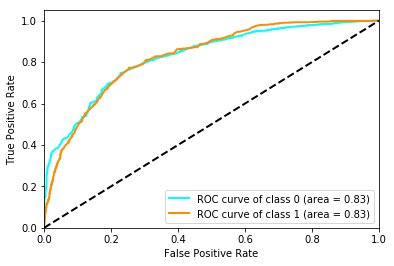

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.884181    0.514793     0.699487     0.812999      0.805080
precision     0.861310    0.579228     0.720269     0.812999      0.800905
recall        0.908299    0.463259     0.685779     0.812999      0.812999
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.827020    0.827020     0.827171     0.892184           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 179)
(21102, 2)
(4385, 179)
(4385, 2)
(21102, 8, 8)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

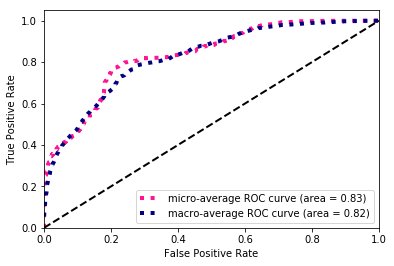

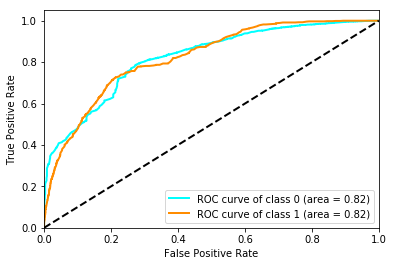

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.849489    0.579585     0.714537     0.778335      0.791692
precision     0.910691    0.487983     0.699337     0.778335      0.820172
recall        0.795995    0.713525     0.754760     0.778335      0.778335
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.821846    0.821846     0.822015     0.832114           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 195)
(21102, 2)
(4385, 195)
(4385, 2)
(21102, 8, 10)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

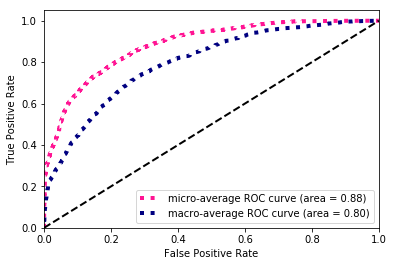

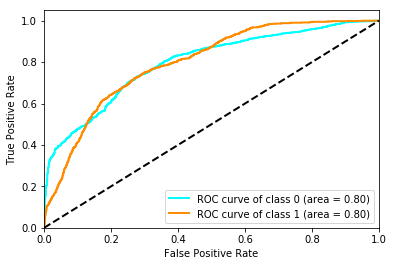

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.869202    0.503282     0.686242     0.792930      0.790844
precision     0.862986    0.517435     0.690211     0.792930      0.788990
recall        0.875508    0.489883     0.682695     0.792930      0.792930
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.797304    0.797304     0.797601     0.882298           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 195)
(21102, 2)
(4385, 195)
(4385, 2)
(21102, 8, 10)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

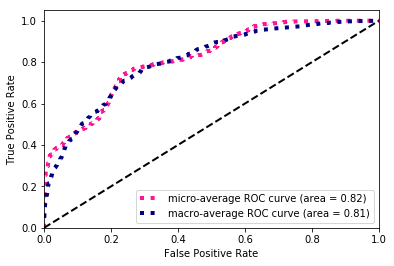

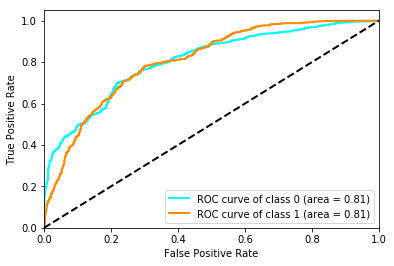

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.827075    0.549342     0.688208     0.750057      0.767601
precision     0.906293    0.447421     0.676857     0.750057      0.808031
recall        0.760592    0.711395     0.735994     0.750057      0.750057
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.806403    0.806403     0.806703     0.815738           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 195)
(21102, 2)
(4385, 195)
(4385, 2)
(21102, 8, 10)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

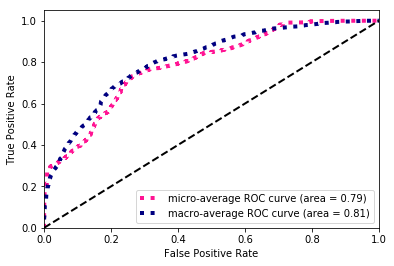

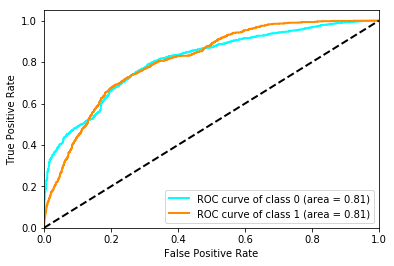

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.812430    0.544744     0.678587     0.734322      0.755108
precision     0.912477    0.430247     0.671362     0.734322      0.809213
recall        0.732153    0.742279     0.737216     0.734322      0.734322
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.808928    0.808928     0.809209     0.788079           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(21102, 171)
(21102, 2)
(4385, 171)
(4385, 2)
(21102, 8, 7)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

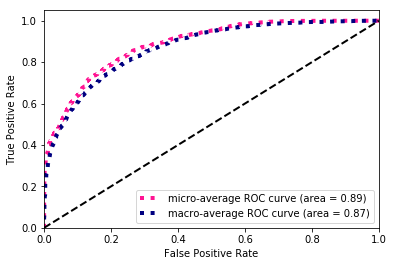

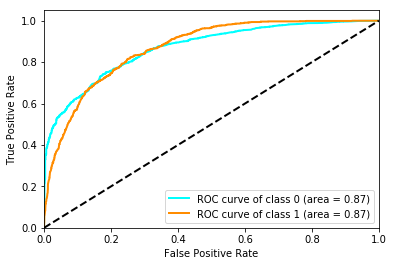

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.860315    0.603327     0.731821     0.793387      0.805284
precision     0.917763    0.512268     0.715015     0.793387      0.830931
recall        0.809634    0.733759     0.771697     0.793387      0.793387
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.868439    0.868439     0.868548     0.885709           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(21102, 171)
(21102, 2)
(4385, 171)
(4385, 2)
(21102, 8, 7)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

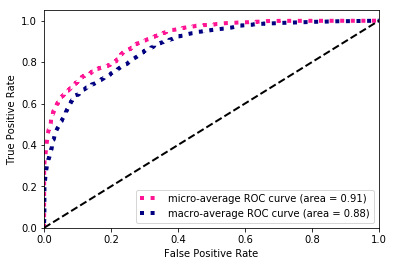

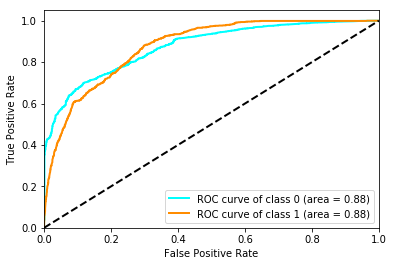

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.864081    0.599460     0.731770     0.797035      0.807415
precision     0.911992    0.519096     0.715544     0.797035      0.827858
recall        0.820952    0.709265     0.765109     0.797035      0.797035
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.875040    0.875040     0.875155     0.909396           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(21102, 171)
(21102, 2)
(4385, 171)
(4385, 2)
(21102, 8, 7)
(21102,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

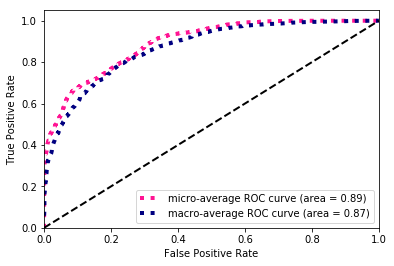

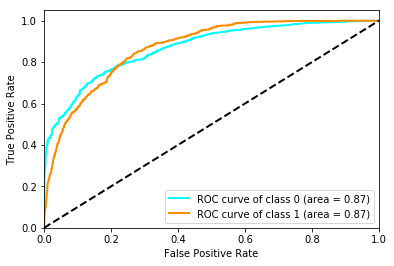

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.850964    0.601925     0.726445     0.783124      0.797635
precision     0.925043    0.495862     0.710452     0.783124      0.833138
recall        0.787870    0.765708     0.776789     0.783124      0.783124
support    3446.000000  939.000000  4385.000000  4385.000000   4385.000000
auc           0.868975    0.868975     0.869087     0.891872           NaN

In [22]:
Charlotte = compare_models(city='Charlotte',classname='RNN_embed')

In [23]:
Charlotte.to_hdf('Charlotte.h5',key='RNN_embed_only')
Charlotte

traffic   weather      time
0_f1-score              0.811314  0.836235  0.858453
1_f1-score              0.528848  0.532456  0.601571
weighted avg_f1-score   0.750827  0.771184  0.803445
micro avg_f1-score      0.738122  0.759103  0.791182
macro avg_f1-score      0.670081  0.684346  0.730012
0_precision             0.901767  0.893919  0.918266
1_precision             0.471022  0.465035  0.509075
weighted avg_precision  0.809528  0.802078  0.830642
micro avg_precision     0.738122  0.759103  0.791182
macro avg_precision     0.686394  0.679477  0.713671
0_recall                0.754885  0.789418  0.806152
1_recall                0.676606  0.647852  0.736244
weighted avg_recall     0.738122  0.759103  0.791182
micro avg_recall        0.738122  0.759103  0.791182
macro avg_recall        0.715746  0.718635  0.771198
0_auc                   0.824157  0.804211  0.870818
1_auc                   0.824157  0.804211  0.870818
micro avg_auc           0.823694  0.828705  0.895659
macro avg_auc           0.824324  0.804504  0.870930

# dallas

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 100)
(26555, 2)
(5345, 100)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_283 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_284 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_133 (Bat (None, 256)               1024      
_________________________________________________________________
activation_133 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_67 (Dropout)         (None, 256)         

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


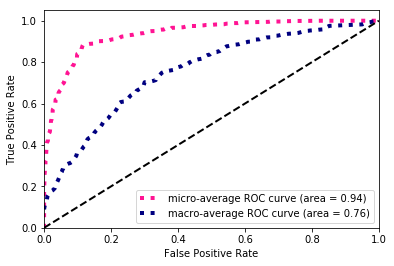

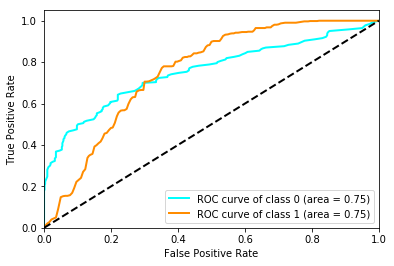

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.754908    0.754908     0.755034     0.936053           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 100)
(26555, 2)
(5345, 100)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_287 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_288 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_135 (Bat (None, 256)               1024      
_________________________________________________________________
activation_135 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_68 (Dropout)         (None, 256)         

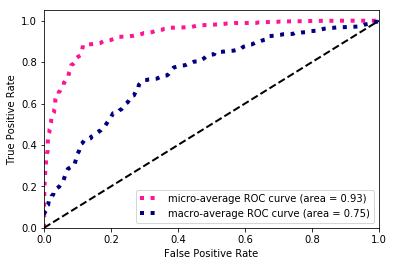

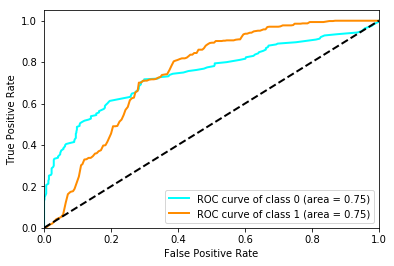

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.746246    0.746242     0.746374     0.934271           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 100)
(26555, 2)
(5345, 100)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 100)               0         
_________________________________________________________________
dense_291 (Dense)            (None, 512)               51712     
_________________________________________________________________
dense_292 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_137 (Bat (None, 256)               1024      
_________________________________________________________________
activation_137 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 256)         

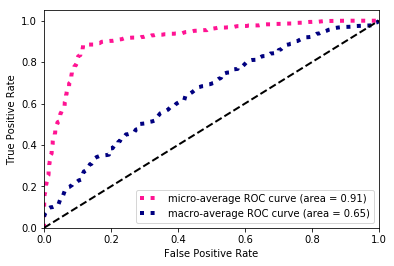

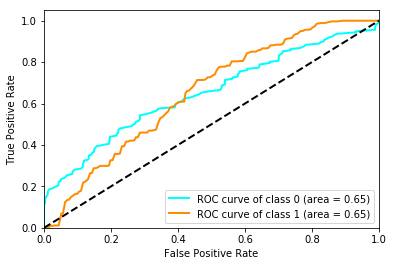

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.650926    0.650926     0.651081     0.914668           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 14)
(26555, 2)
(5345, 14)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_295 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_296 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_139 (Bat (None, 256)               1024      
_________________________________________________________________
activation_139 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 256)           

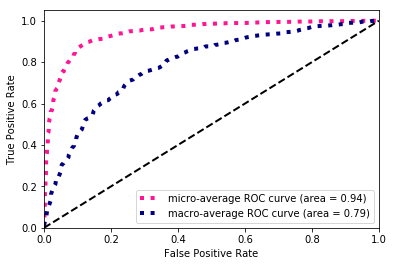

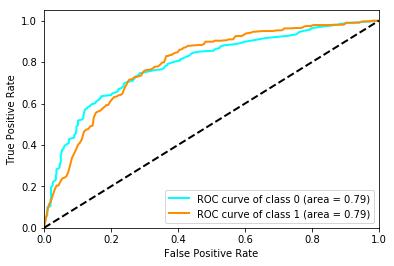

0           1    macro avg   micro avg  weighted avg
index                                                                    
f1-score      0.938220    0.000000     0.469110     0.88363      0.829039
precision     0.883630    0.000000     0.441815     0.88363      0.780801
recall        1.000000    0.000000     0.500000     0.88363      0.883630
support    4723.000000  622.000000  5345.000000  5345.00000   5345.000000
auc           0.790825    0.790825     0.791059     0.94344           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 14)
(26555, 2)
(5345, 14)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_299 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_300 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_141 (Bat (None, 256)               1024      
_________________________________________________________________
activation_141 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 256)           

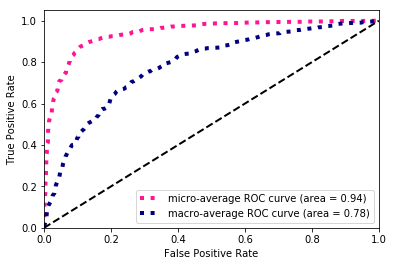

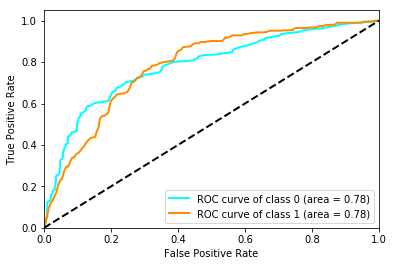

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.937020    0.059613     0.498316     0.881946      0.834915
precision     0.886329    0.408163     0.647246     0.881946      0.830685
recall        0.993860    0.032154     0.513007     0.881946      0.881946
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.783443    0.783443     0.783675     0.941906           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 14)
(26555, 2)
(5345, 14)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 14)                0         
_________________________________________________________________
dense_303 (Dense)            (None, 512)               7680      
_________________________________________________________________
dense_304 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_143 (Bat (None, 256)               1024      
_________________________________________________________________
activation_143 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 256)           

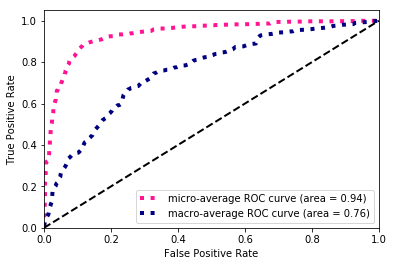

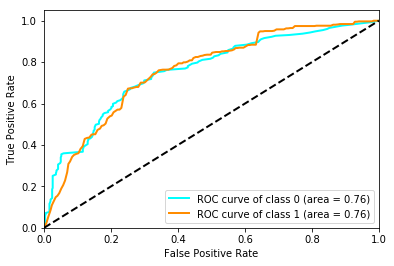

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.758412    0.758412     0.758633     0.936774           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 64)
(26555, 2)
(5345, 64)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_307 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_308 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_145 (Bat (None, 256)               1024      
_________________________________________________________________
activation_145 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_73 (Dropout)         (None, 256)           

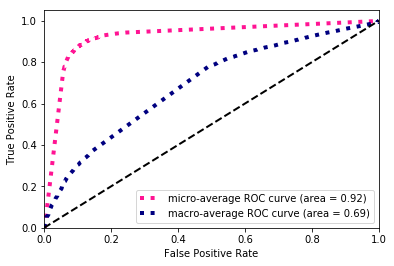

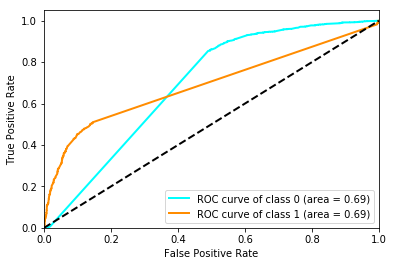

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938494    0.109986     0.524240     0.884939      0.842080
precision     0.889310    0.550725     0.720017     0.884939      0.849909
recall        0.993436    0.061093     0.527265     0.884939      0.884939
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.689916    0.689916     0.690020     0.922779           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 64)
(26555, 2)
(5345, 64)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_311 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_312 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_147 (Bat (None, 256)               1024      
_________________________________________________________________
activation_147 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 256)           

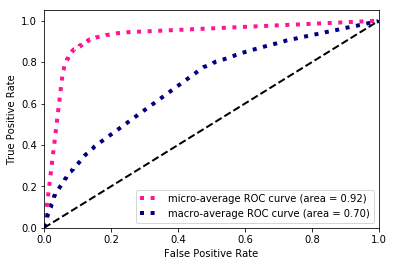

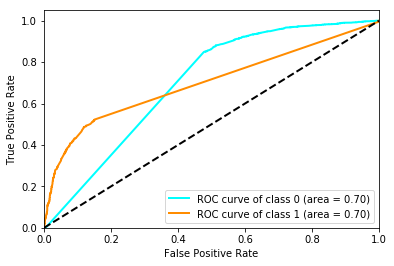

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938301    0.127479     0.532890     0.884752      0.843946
precision     0.890325    0.535714     0.713020     0.884752      0.849059
recall        0.991743    0.072347     0.532045     0.884752      0.884752
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.698780    0.698780     0.698887     0.924566           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 64)
(26555, 2)
(5345, 64)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 64)                0         
_________________________________________________________________
dense_315 (Dense)            (None, 512)               33280     
_________________________________________________________________
dense_316 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_149 (Bat (None, 256)               1024      
_________________________________________________________________
activation_149 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_75 (Dropout)         (None, 256)           

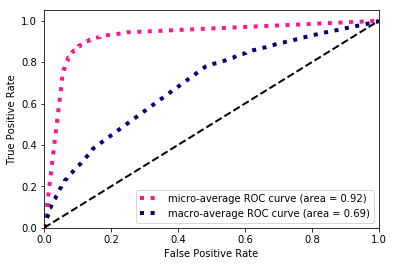

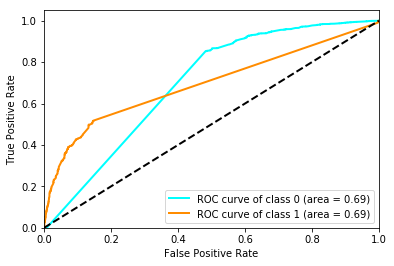

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.939266    0.148876     0.544071     0.886623      0.847288
precision     0.891722    0.588889     0.740306     0.886623      0.856481
recall        0.992166    0.085209     0.538687     0.886623      0.886623
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.694286    0.694286     0.694401     0.923650           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 80)
(26555, 2)
(5345, 80)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_319 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_320 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_151 (Bat (None, 256)               1024      
_________________________________________________________________
activation_151 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 256)           

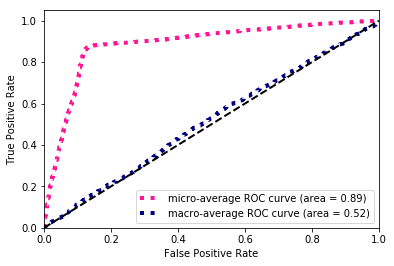

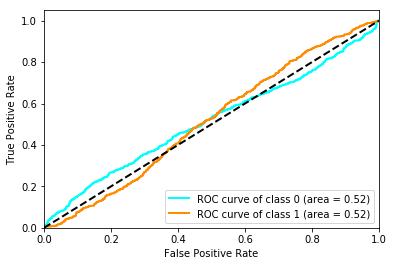

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.930624    0.011412     0.471018     0.870346      0.823655
precision     0.882643    0.050633     0.466638     0.870346      0.785822
recall        0.984120    0.006431     0.495276     0.870346      0.870346
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.515071    0.515071     0.515335     0.885116           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 80)
(26555, 2)
(5345, 80)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_323 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_324 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_153 (Bat (None, 256)               1024      
_________________________________________________________________
activation_153 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_77 (Dropout)         (None, 256)           

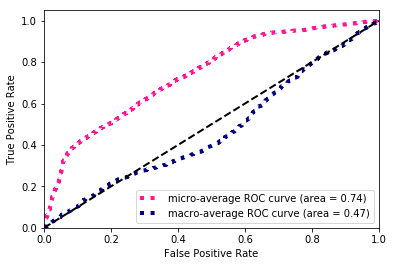

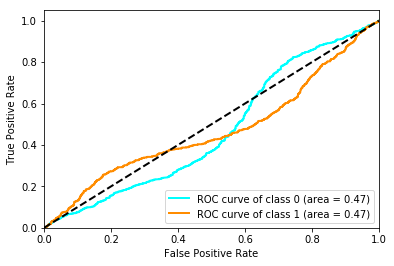

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.786626    0.188679     0.487652     0.662114      0.717042
precision     0.889869    0.130923     0.510396     0.662114      0.801550
recall        0.704849    0.337621     0.521235     0.662114      0.662114
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.469079    0.469079     0.469346     0.740547           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 80)
(26555, 2)
(5345, 80)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 80)                0         
_________________________________________________________________
dense_327 (Dense)            (None, 512)               41472     
_________________________________________________________________
dense_328 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_155 (Bat (None, 256)               1024      
_________________________________________________________________
activation_155 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 256)           

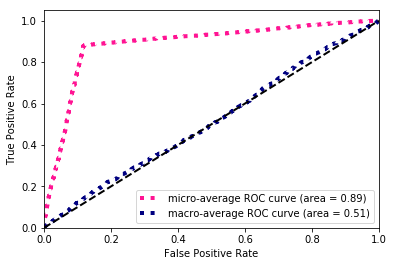

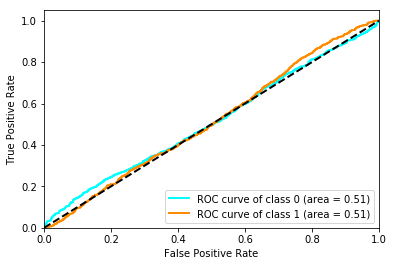

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.936318    0.000000     0.468159     0.880262      0.827359
precision     0.883236    0.000000     0.441618     0.880262      0.780454
recall        0.996189    0.000000     0.498094     0.880262      0.880262
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.512961    0.512961     0.513227     0.886226           NaN

******************** DNN ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 56)
(26555, 2)
(5345, 56)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_331 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_332 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_157 (Bat (None, 256)               1024      
_________________________________________________________________
activation_157 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 256)           

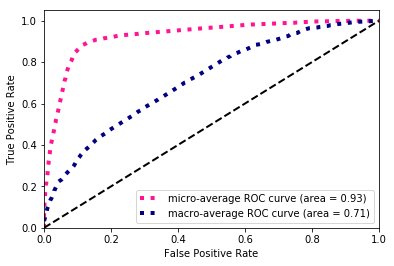

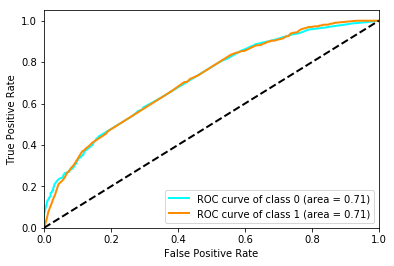

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.713209    0.713209     0.713344     0.927477           NaN

******************** DNN ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 56)
(26555, 2)
(5345, 56)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_335 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_336 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_159 (Bat (None, 256)               1024      
_________________________________________________________________
activation_159 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 256)           

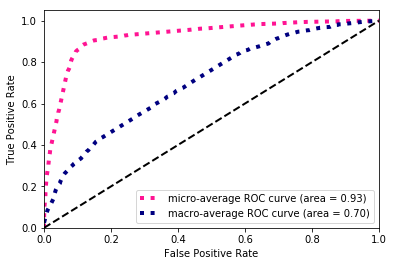

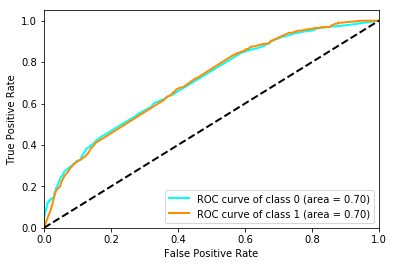

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.704732    0.704732     0.704859     0.925734           NaN

******************** DNN ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 56)
(26555, 2)
(5345, 56)
(5345, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 56)                0         
_________________________________________________________________
dense_339 (Dense)            (None, 512)               29184     
_________________________________________________________________
dense_340 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalization_161 (Bat (None, 256)               1024      
_________________________________________________________________
activation_161 (Activation)  (None, 256)               0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 256)           

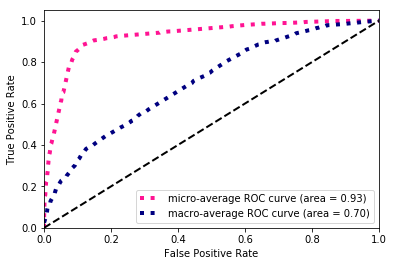

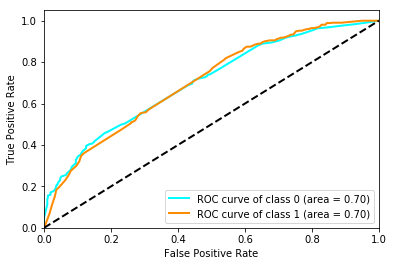

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.702803    0.702803     0.702873     0.925337           NaN

In [24]:
Dallas = compare_models(city='Dallas',classname='DNN')

In [25]:
Dallas.to_hdf('Dallas.h5',key='DNN_only')
Dallas

NL   geohash   traffic   weather      time
0_f1-score              0.938220  0.937820  0.938687  0.884523  0.938220
1_f1-score              0.000000  0.019871  0.128780  0.066697  0.000000
weighted avg_f1-score   0.829039  0.830998  0.844438  0.789352  0.829039
micro avg_f1-score      0.883630  0.883068  0.885438  0.804241  0.883630
macro avg_f1-score      0.469110  0.478845  0.533734  0.475610  0.469110
0_precision             0.883630  0.884529  0.890452  0.885250  0.883630
1_precision             0.000000  0.136054  0.558443  0.060519  0.000000
weighted avg_precision  0.780801  0.797429  0.851816  0.789275  0.780801
micro avg_precision     0.883630  0.883068  0.885438  0.804241  0.883630
macro avg_precision     0.441815  0.510292  0.724448  0.472884  0.441815
0_recall                1.000000  0.997953  0.992448  0.895053  1.000000
1_recall                0.000000  0.010718  0.072883  0.114684  0.000000
weighted avg_recall     0.883630  0.883068  0.885438  0.804241  0.883630
micro avg_recall        0.883630  0.883068  0.885438  0.804241  0.883630
macro avg_recall        0.500000  0.504336  0.532666  0.504868  0.500000
0_auc                   0.717360  0.777560  0.694327  0.499037  0.706915
1_auc                   0.717359  0.777560  0.694327  0.499037  0.706915
micro avg_auc           0.928331  0.940706  0.923665  0.837296  0.926183
macro avg_auc           0.717496  0.777789  0.694436  0.499303  0.707025

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 178)
(26555, 2)
(5345, 178)
(5345, 2)
(26555, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_73 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_74 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_343 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_344 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

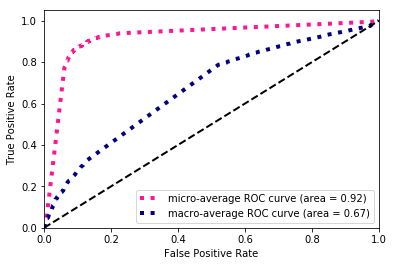

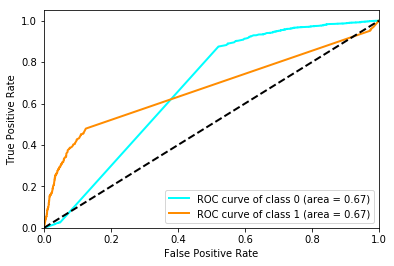

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938334    0.142259     0.540296     0.884939      0.845694
precision     0.891238    0.536842     0.714040     0.884939      0.849997
recall        0.990684    0.081994     0.536339     0.884939      0.884939
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.671862    0.671812     0.671928     0.919013           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 178)
(26555, 2)
(5345, 178)
(5345, 2)
(26555, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_75 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_76 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_347 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_348 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

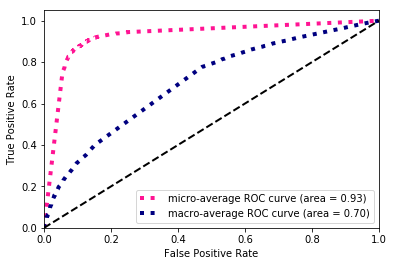

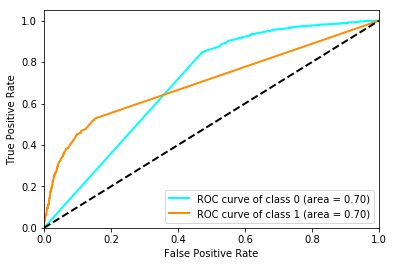

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.939218    0.158333     0.548775     0.886623      0.848346
precision     0.892319    0.581633     0.736976     0.886623      0.856165
recall        0.991319    0.091640     0.541479     0.886623      0.886623
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.702721    0.702671     0.702769     0.925430           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 178)
(26555, 2)
(5345, 178)
(5345, 2)
(26555, 8, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 8)              0         
_________________________________________________________________
lstm_77 (LSTM)               (None, 8, 128)            70144     
_________________________________________________________________
lstm_78 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_351 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_352 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

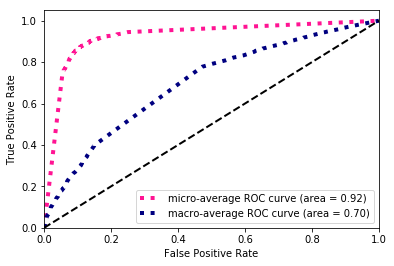

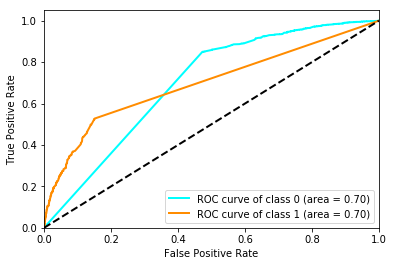

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.936002    0.255319     0.595660     0.882133      0.856790
precision     0.899629    0.482143     0.690886     0.882133      0.851046
recall        0.975439    0.173633     0.574536     0.882133      0.882133
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.696417    0.696367     0.696492     0.923782           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 194)
(26555, 2)
(5345, 194)
(5345, 2)
(26555, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_79 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_80 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_355 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_356 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


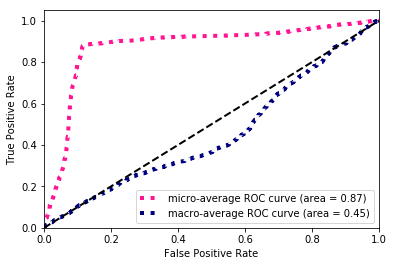

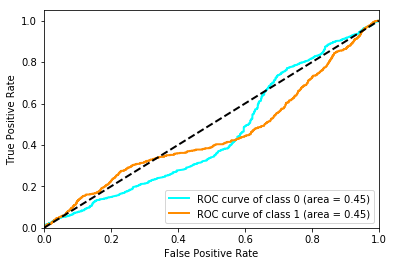

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.451848    0.451842     0.451979     0.873726           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 194)
(26555, 2)
(5345, 194)
(5345, 2)
(26555, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_81 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_82 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_359 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_360 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

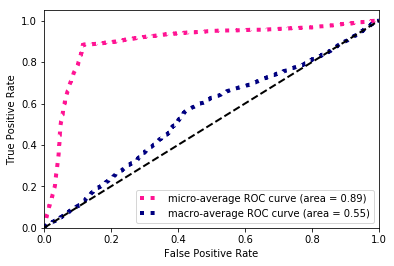

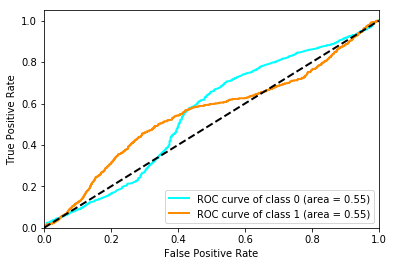

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.549672    0.549677     0.549836     0.893845           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 194)
(26555, 2)
(5345, 194)
(5345, 2)
(26555, 8, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 10)             0         
_________________________________________________________________
lstm_83 (LSTM)               (None, 8, 128)            71168     
_________________________________________________________________
lstm_84 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_363 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_364 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizat

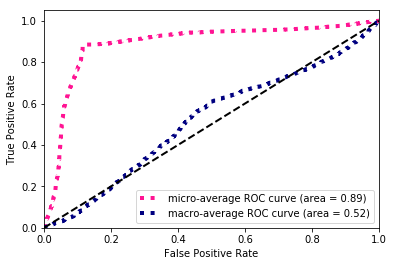

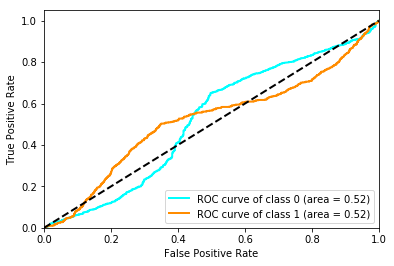

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.517596    0.517602     0.517767     0.887249           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 170)
(26555, 2)
(5345, 170)
(5345, 2)
(26555, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_85 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_86 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_367 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_368 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

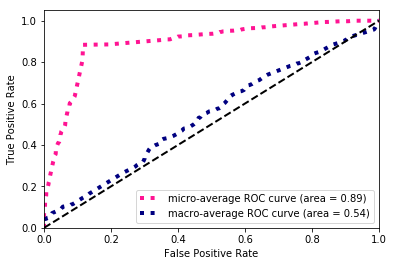

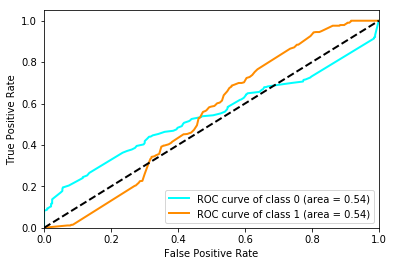

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.541174    0.541174     0.541258     0.892097           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 170)
(26555, 2)
(5345, 170)
(5345, 2)
(26555, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_87 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_88 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_371 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_372 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

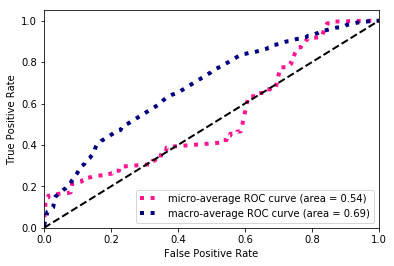

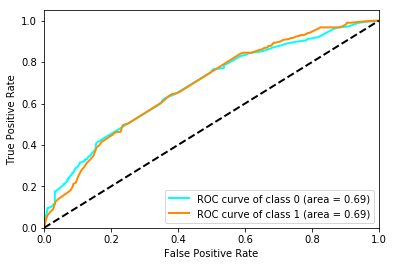

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.554806    0.261626     0.408216     0.444528      0.520688
precision     0.950668    0.154751     0.552710     0.444528      0.858047
recall        0.391700    0.845659     0.618680     0.444528      0.444528
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.685610    0.685610     0.685852     0.535437           NaN

******************** RNN_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 170)
(26555, 2)
(5345, 170)
(5345, 2)
(26555, 8, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 8, 7)              0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 8, 128)            69632     
_________________________________________________________________
lstm_90 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_375 (Dense)            (None, 512)               66048     
_________________________________________________________________
dense_376 (Dense)            (None, 256)               131328    
_________________________________________________________________
batch_normalizati

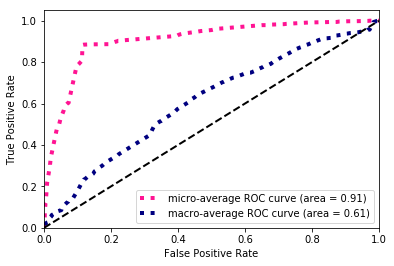

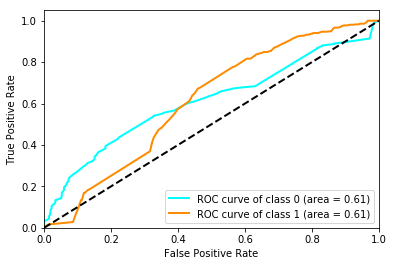

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.609988    0.609988     0.610125     0.906249           NaN

In [26]:
Dallas = compare_models(city='Dallas',classname='RNN')

In [27]:
Dallas.to_hdf('Dallas.h5',key='RNN_only')
Dallas

traffic   weather      time
0_f1-score              0.937851  0.938220  0.810415
1_f1-score              0.185304  0.000000  0.087209
weighted avg_f1-score   0.850277  0.829039  0.726255
micro avg_f1-score      0.884565  0.883630  0.737262
macro avg_f1-score      0.561577  0.469110  0.448812
0_precision             0.894395  0.883630  0.905976
1_precision             0.533539  0.000000  0.051584
weighted avg_precision  0.852402  0.780801  0.806550
micro avg_precision     0.884565  0.883630  0.737262
macro avg_precision     0.713967  0.441815  0.478780
0_recall                0.985814  1.000000  0.797233
1_recall                0.115756  0.000000  0.281886
weighted avg_recall     0.884565  0.883630  0.737262
micro avg_recall        0.884565  0.883630  0.737262
macro avg_recall        0.550785  0.500000  0.539560
0_auc                   0.690333  0.506372  0.612257
1_auc                   0.690283  0.506374  0.612257
micro avg_auc           0.922742  0.884940  0.777928
macro avg_auc           0.690396  0.506527  0.612412

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 179)
(26555, 2)
(5345, 179)
(5345, 2)
(26555, 8, 8)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

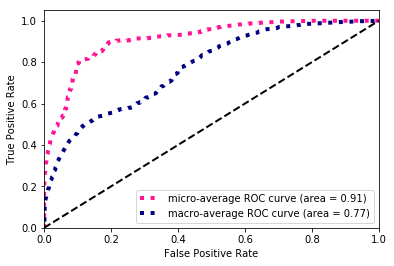

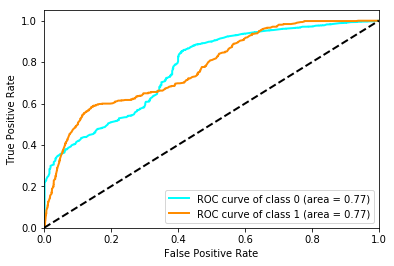

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.910180    0.451827     0.681003     0.845650      0.856841
precision     0.936800    0.385051     0.660925     0.845650      0.872592
recall        0.885031    0.546624     0.715827     0.845650      0.845650
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.772188    0.772189     0.772410     0.911205           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 179)
(26555, 2)
(5345, 179)
(5345, 2)
(26555, 8, 8)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

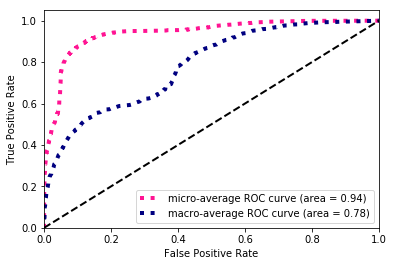

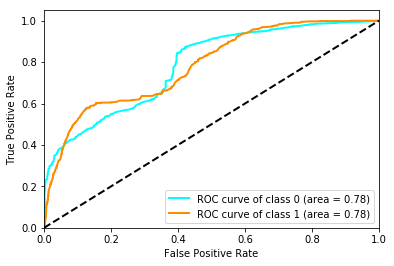

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.939298    0.356135     0.647716     0.889055      0.871435
precision     0.909235    0.548495     0.728865     0.889055      0.867256
recall        0.971416    0.263666     0.617541     0.889055      0.889055
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.782676    0.782676     0.782847     0.939898           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 179)
(26555, 2)
(5345, 179)
(5345, 2)
(26555, 8, 8)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 8)         0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

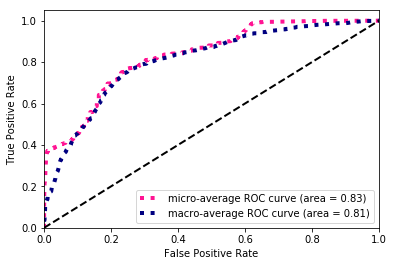

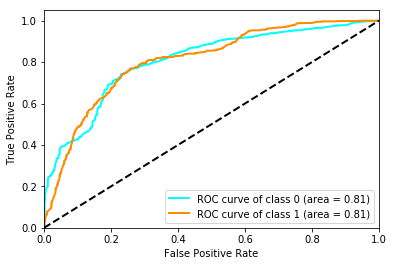

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.843976    0.414406     0.629191     0.753601      0.793987
precision     0.958042    0.286417     0.622229     0.753601      0.879885
recall        0.754182    0.749196     0.751689     0.753601      0.753601
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.807059    0.807059     0.807257     0.831014           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 195)
(26555, 2)
(5345, 195)
(5345, 2)
(26555, 8, 10)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

/users/PAS0536/osu9965/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


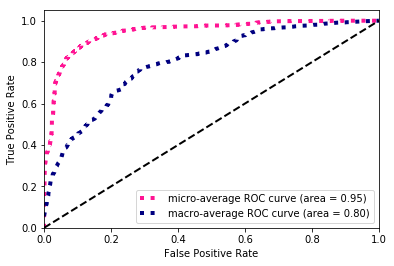

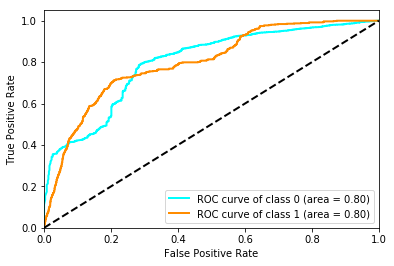

0          1    macro avg    micro avg  weighted avg
index                                                                   
f1-score      0.93822    0.00000     0.469110     0.883630      0.829039
precision     0.88363    0.00000     0.441815     0.883630      0.780801
recall        1.00000    0.00000     0.500000     0.883630      0.883630
support    4723.00000  622.00000  5345.000000  5345.000000   5345.000000
auc           0.79863    0.79865     0.799015     0.945047           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 195)
(26555, 2)
(5345, 195)
(5345, 2)
(26555, 8, 10)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

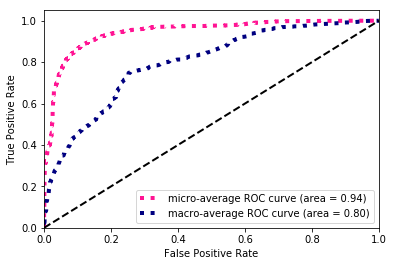

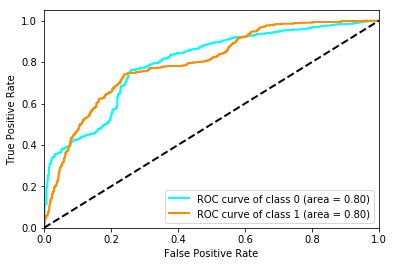

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.938220    0.000000     0.469110     0.883630      0.829039
precision     0.883630    0.000000     0.441815     0.883630      0.780801
recall        1.000000    0.000000     0.500000     0.883630      0.883630
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.796164    0.796165     0.796518     0.944538           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 195)
(26555, 2)
(5345, 195)
(5345, 2)
(26555, 8, 10)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 10)        0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
l

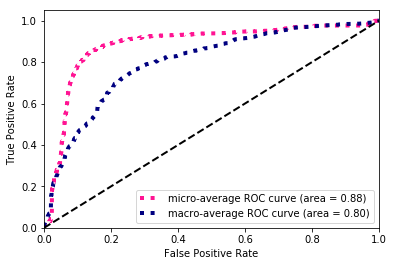

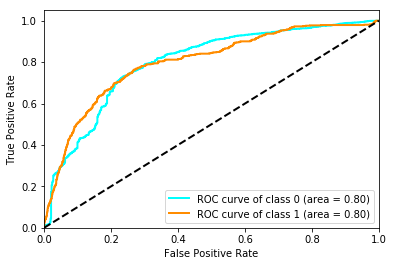

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.917920    0.447178     0.682549     0.857063      0.863140
precision     0.931734    0.406579     0.669156     0.857063      0.870621
recall        0.904510    0.496785     0.700647     0.857063      0.857063
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.798049    0.798049     0.798459     0.883269           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  0
load and test: shapes for train and test, X/Y
(26555, 171)
(26555, 2)
(5345, 171)
(5345, 2)
(26555, 8, 7)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

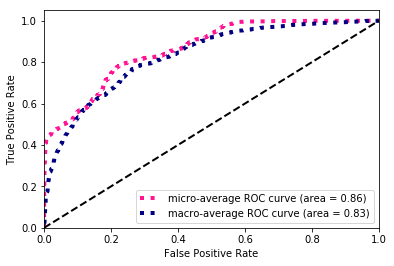

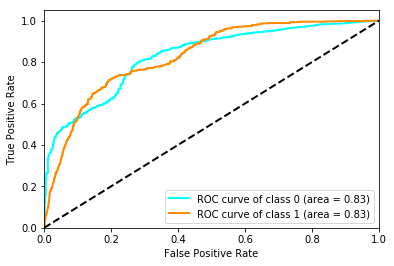

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.862690    0.434658     0.648674     0.779046      0.812880
precision     0.956679    0.309475     0.633077     0.779046      0.881363
recall        0.785518    0.729904     0.757711     0.779046      0.779046
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.829211    0.829211     0.829370     0.861840           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  1
load and test: shapes for train and test, X/Y
(26555, 171)
(26555, 2)
(5345, 171)
(5345, 2)
(26555, 8, 7)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

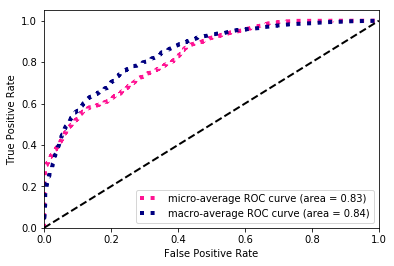

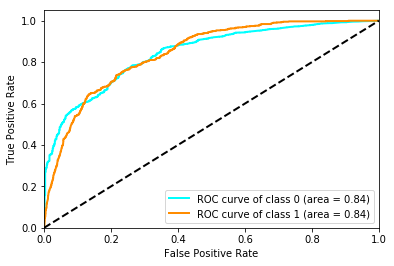

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.816396    0.396310     0.606353     0.718428      0.767511
precision     0.963155    0.264030     0.613592     0.718428      0.881797
recall        0.708448    0.794212     0.751330     0.718428      0.718428
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.843993    0.843993     0.844113     0.825380           NaN

******************** RNN_embed_wo_NLP_wo_geohash ********************
**********  round  2
load and test: shapes for train and test, X/Y
(26555, 171)
(26555, 2)
(5345, 171)
(5345, 2)
(26555, 8, 7)
(26555,)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_code (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 8, 7)         0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 1, 128)       119680      geo_code[0][0]                   
__________________________________________________________________________________________________
ls

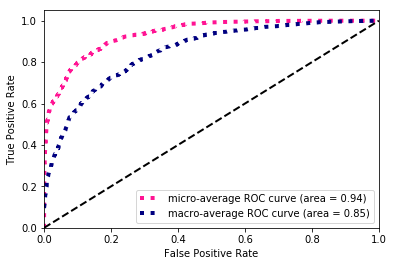

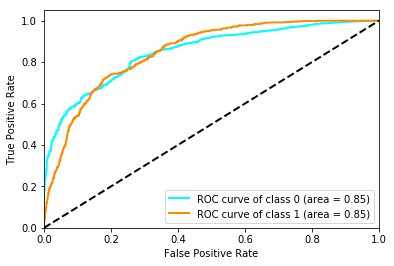

0           1    macro avg    micro avg  weighted avg
index                                                                     
f1-score      0.914590    0.476318     0.695454     0.853134      0.863588
precision     0.940689    0.407070     0.673879     0.853134      0.878592
recall        0.889900    0.573955     0.731928     0.853134      0.853134
support    4723.000000  622.000000  5345.000000  5345.000000   5345.000000
auc           0.850129    0.850129     0.850250     0.936232           NaN

In [28]:
Dallas = compare_models(city='Dallas',classname='RNN_embed')

In [29]:
Dallas.to_hdf('Dallas.h5',key='RNN_embed_only')
Dallas

traffic   weather      time
0_f1-score              0.897818  0.931453  0.864559
1_f1-score              0.407456  0.149059  0.435762
weighted avg_f1-score   0.840754  0.840406  0.814660
micro avg_f1-score      0.829436  0.874774  0.783536
macro avg_f1-score      0.652637  0.540256  0.650160
0_precision             0.934692  0.899664  0.953508
1_precision             0.406654  0.135526  0.326858
weighted avg_precision  0.873244  0.810741  0.880584
micro avg_precision     0.829436  0.874774  0.783536
macro avg_precision     0.670673  0.517595  0.640183
0_recall                0.870210  0.968170  0.794622
1_recall                0.519829  0.165595  0.699357
weighted avg_recall     0.829436  0.874774  0.783536
micro avg_recall        0.829436  0.874774  0.783536
macro avg_recall        0.695019  0.566882  0.746989
0_auc                   0.787308  0.797614  0.841111
1_auc                   0.787308  0.797621  0.841111
micro avg_auc           0.894039  0.924285  0.874484
macro avg_auc           0.787505  0.797997  0.841244